In [1]:
# Install PyTorch Geometric & dependensinya untuk Colab
!pip install torch==2.0.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric
!pip install pandas scikit-learn matplotlib
!pip install seaborn

# Downgrade NumPy ke versi stabil 1.x untuk kompatibilitas
!pip install numpy==1.24.4



Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 556.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 93.0 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import ast


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0+cu118


In [2]:
class PTGraphDataset(Dataset):
    def __init__(self, pt_file, transform=None):
        self.data_list = torch.load(pt_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        return self.transform(data) if self.transform else data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

train_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/80_20/cnn_cm/train_cnn_cm.pt",weights_only=False)
test_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/80_20/cnn_cm/test_cnn_cm.pt",weights_only=False)
val_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/80_20/cnn_cm/val_cnn_cm.pt", weights_only=False)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
print(f"Total graph: {len(train_data)}")
print(f"Total graph: {len(test_data)}")
print(f"Total graph: {len(val_data)}")

Total graph: 15360
Total graph: 4800
Total graph: 3840


In [6]:
import random

param_grid = {
    'lr': [0.0001, 0.0005, 0.001],
    'hidden_channels': [64, 128, 256],
    'dropout': [0.0, 0.2, 0.4, 0.6],
    'weight_decay': [1e-5, 1e-4, 5e-4, 1e-3],
}


In [7]:
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [8]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


In [9]:
import matplotlib.pyplot as plt

def train_gcn_once(params, train_loader, val_loader, in_channels, num_classes, use_early_stopping=True):
    model = GCNGraphClassifier(in_channels=in_channels,
                                hidden_channels=params['hidden_channels'],
                                num_classes=num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.1, 0.917], device=device))
    dropout_layer = torch.nn.Dropout(params['dropout'])

    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = None
    epochs_without_improvement = 0
    patience = 30
    max_epochs = 200

    # Untuk plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)

        train_acc = accuracy_score(train_labels, train_preds)
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item()
                preds = out.argmax(dim=1).cpu().numpy()
                labels = batch.y.cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        # Simpan untuk plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if use_early_stopping and epochs_without_improvement >= patience:
            print(f"⛔ Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot hasil
    plt.figure(figsize=(14, 5))

    # (a) Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='red')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.text(0, -0.02, '(a)', transform=plt.gca().transAxes)

    # (b) Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.text(0, -0.02, '(b)', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    return best_val_acc, best_val_loss, model


90 10


🔎 Eksperimen 1/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.6, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 38


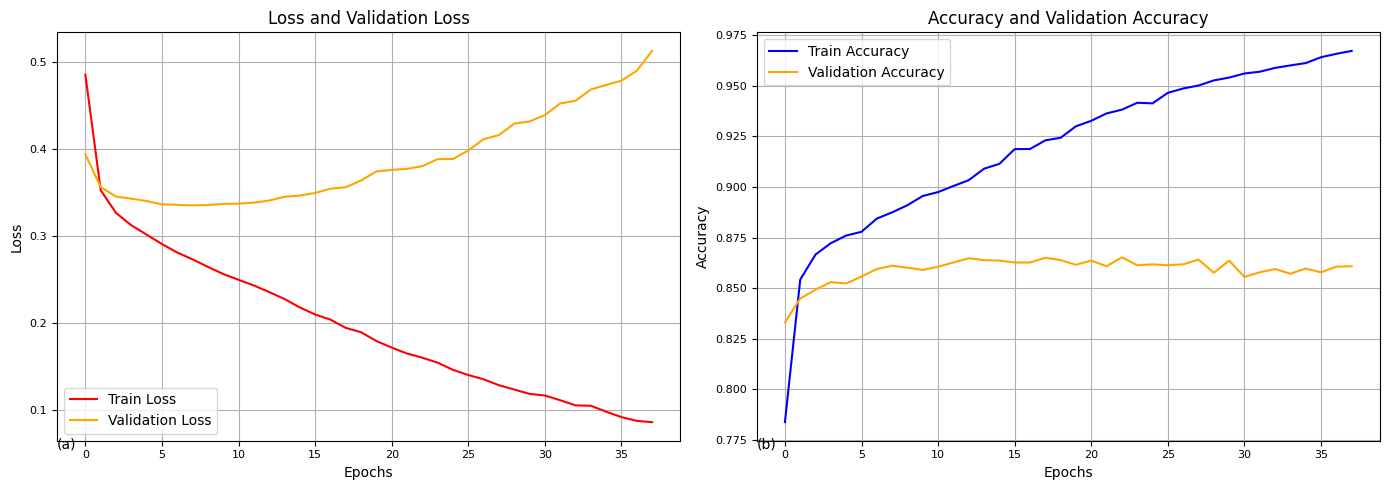

➡️ Val Accuracy: 0.8611 | Val Loss: 0.3352

🔎 Eksperimen 2/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 43


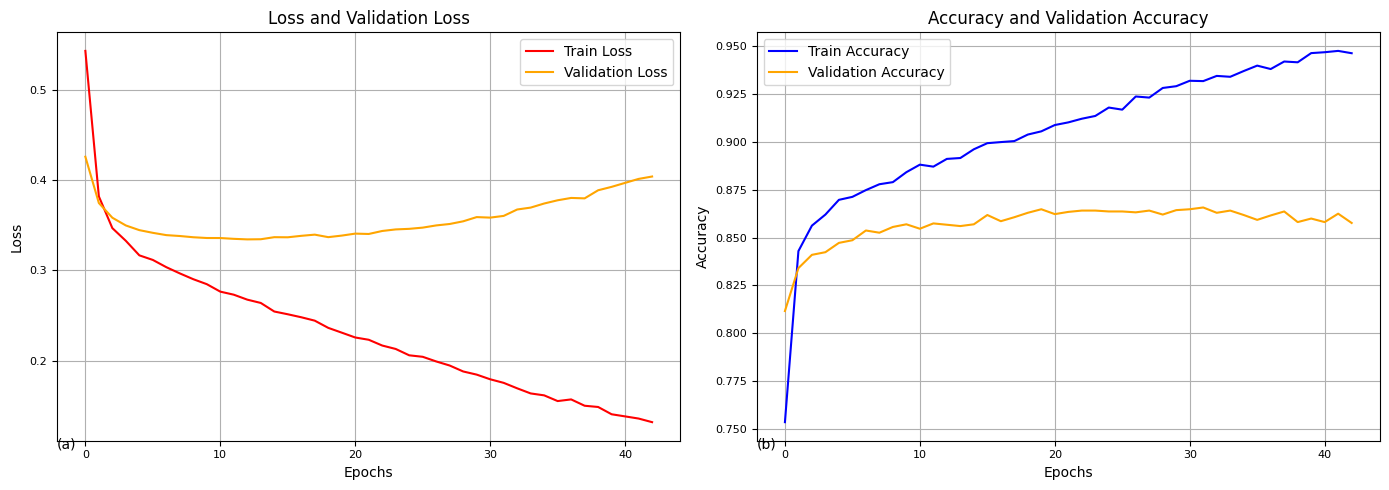

➡️ Val Accuracy: 0.8567 | Val Loss: 0.3344

🔎 Eksperimen 3/20: {'lr': 0.0005, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 32


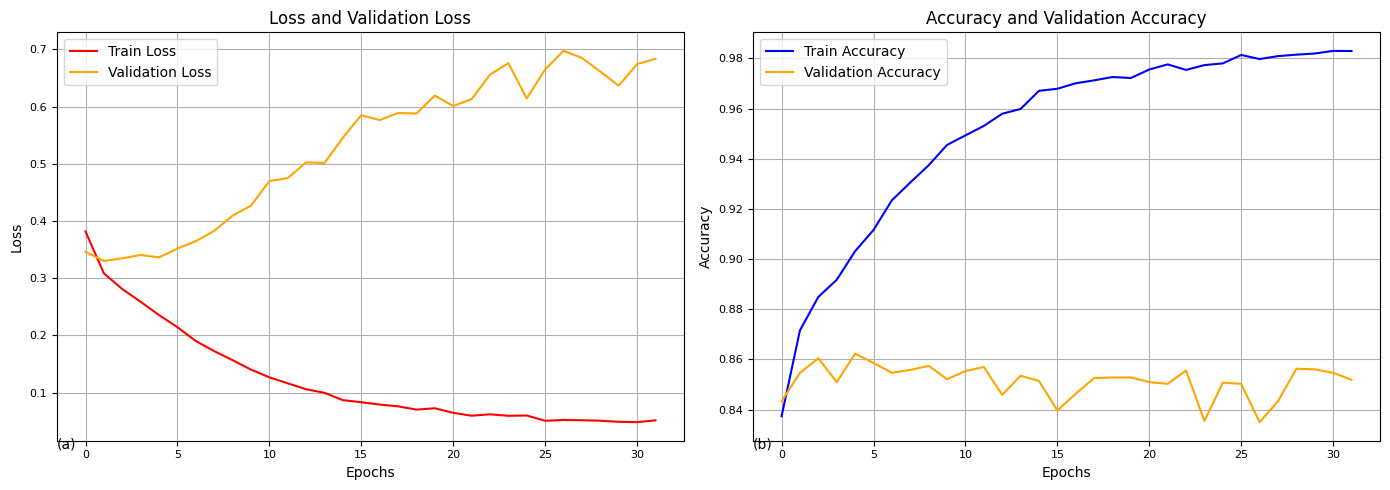

➡️ Val Accuracy: 0.8546 | Val Loss: 0.3302

🔎 Eksperimen 4/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.6, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 34


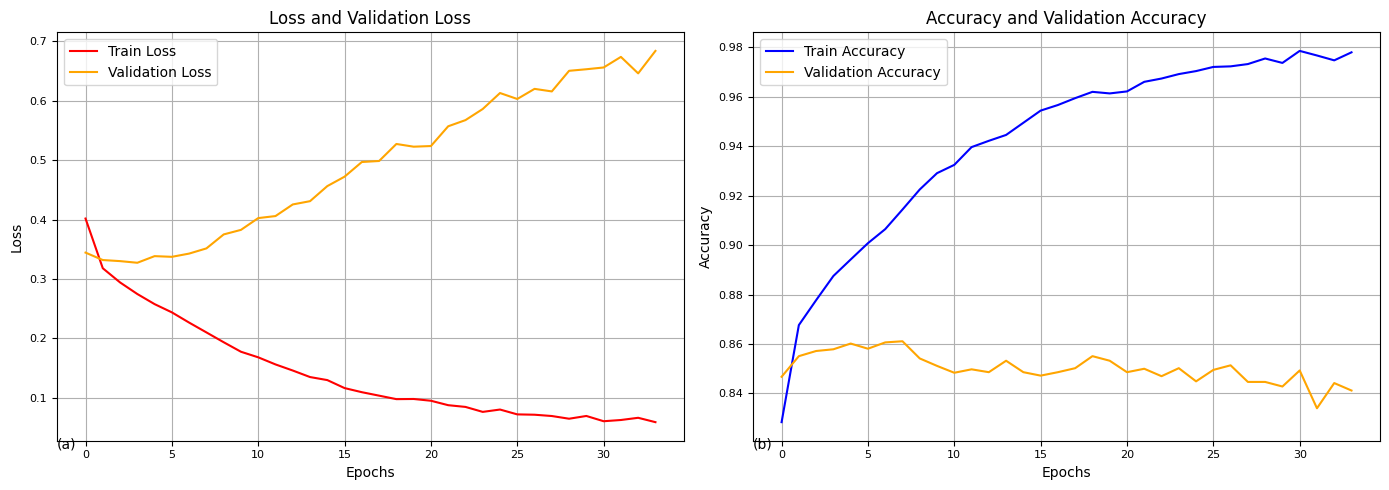

➡️ Val Accuracy: 0.8579 | Val Loss: 0.3272

🔎 Eksperimen 5/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.0001}
⛔ Early stopping at epoch 34


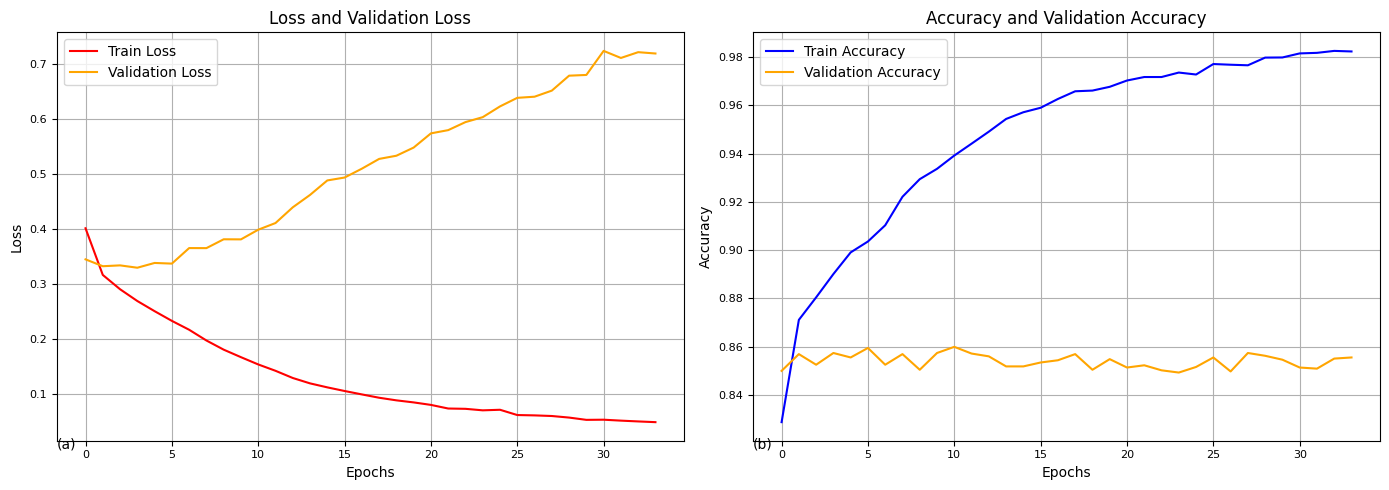

➡️ Val Accuracy: 0.8574 | Val Loss: 0.3295

🔎 Eksperimen 6/20: {'lr': 0.0001, 'hidden_channels': 256, 'dropout': 0.0, 'weight_decay': 0.001}
⛔ Early stopping at epoch 37


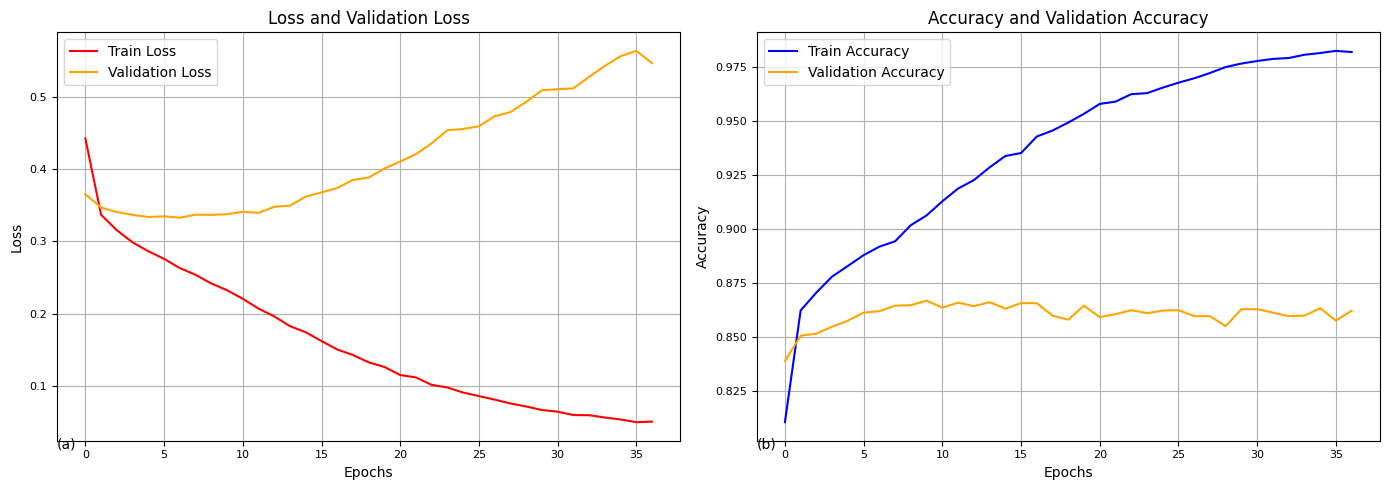

➡️ Val Accuracy: 0.8618 | Val Loss: 0.3329

🔎 Eksperimen 7/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.4, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 41


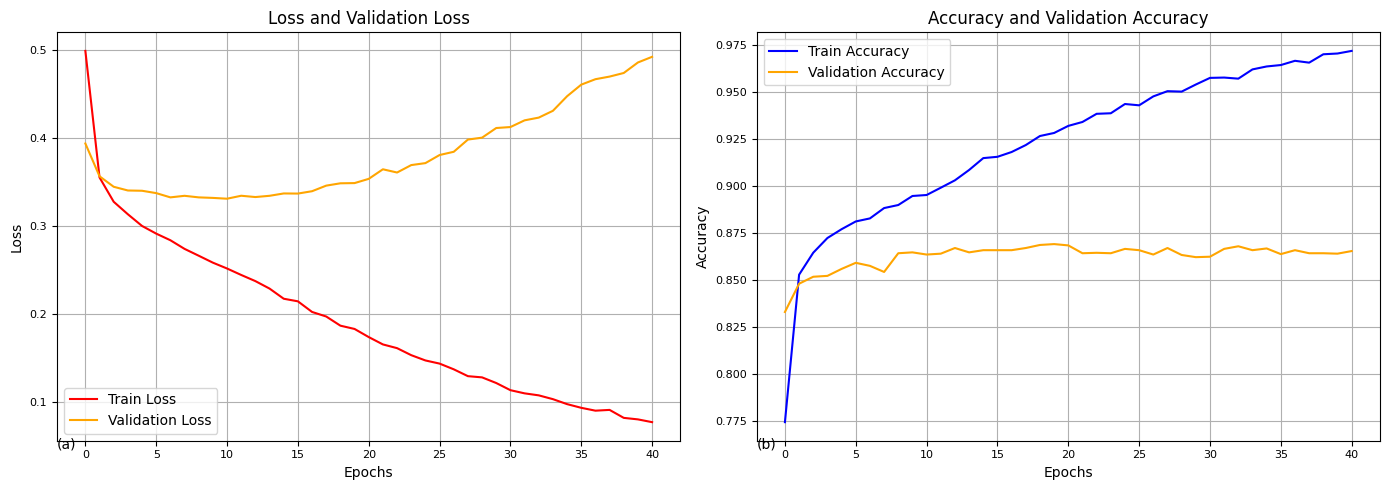

➡️ Val Accuracy: 0.8634 | Val Loss: 0.3309

🔎 Eksperimen 8/20: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.4, 'weight_decay': 0.001}
⛔ Early stopping at epoch 33


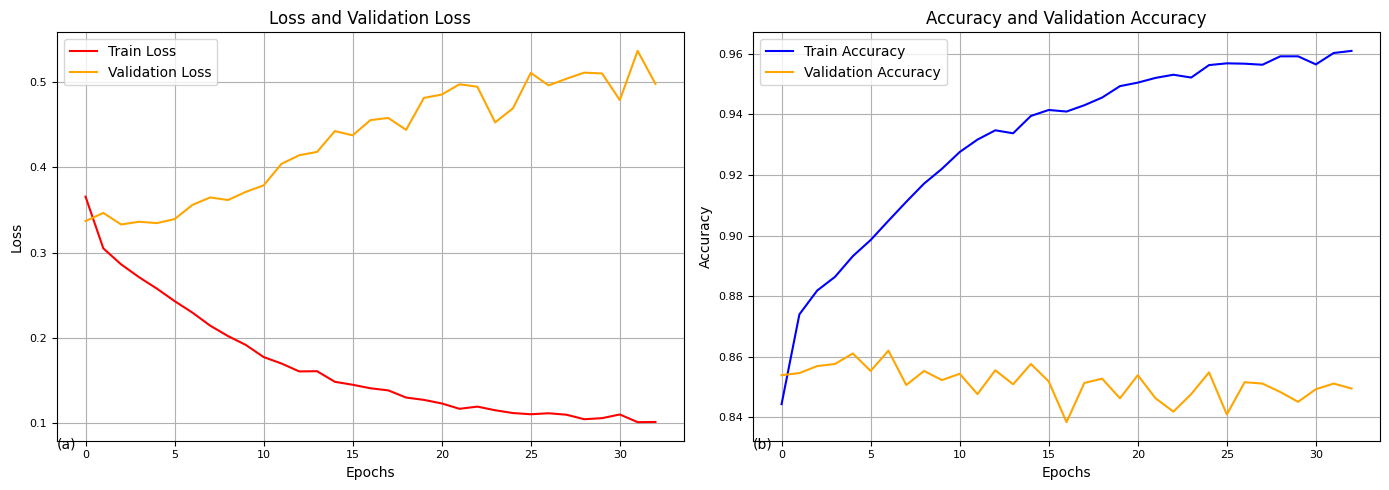

➡️ Val Accuracy: 0.8569 | Val Loss: 0.3329

🔎 Eksperimen 9/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 39


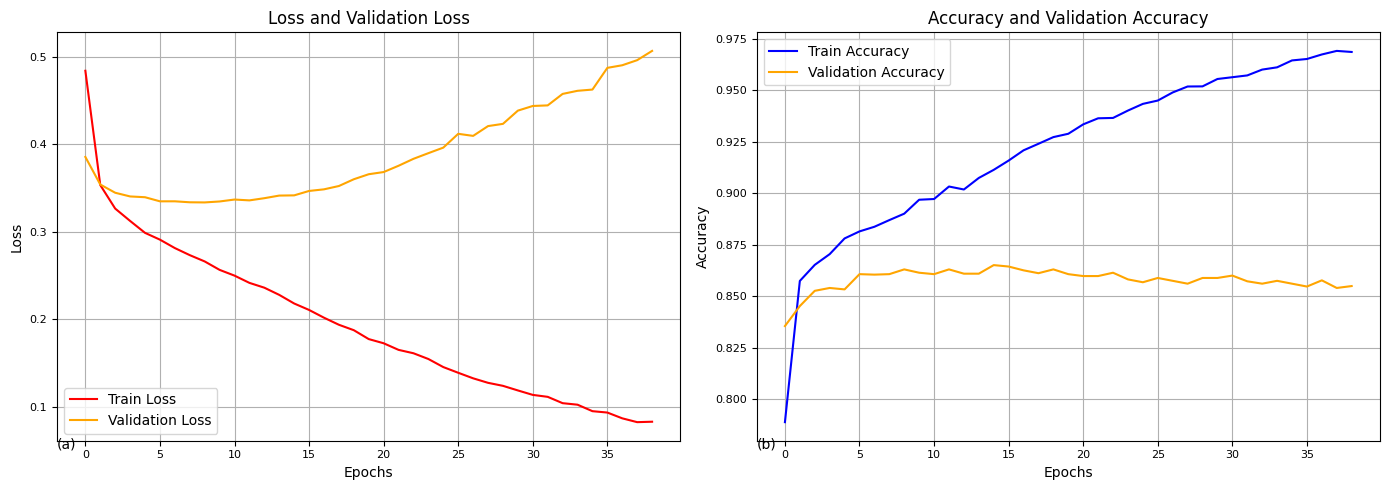

➡️ Val Accuracy: 0.8630 | Val Loss: 0.3334

🔎 Eksperimen 10/20: {'lr': 0.001, 'hidden_channels': 64, 'dropout': 0.6, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 32


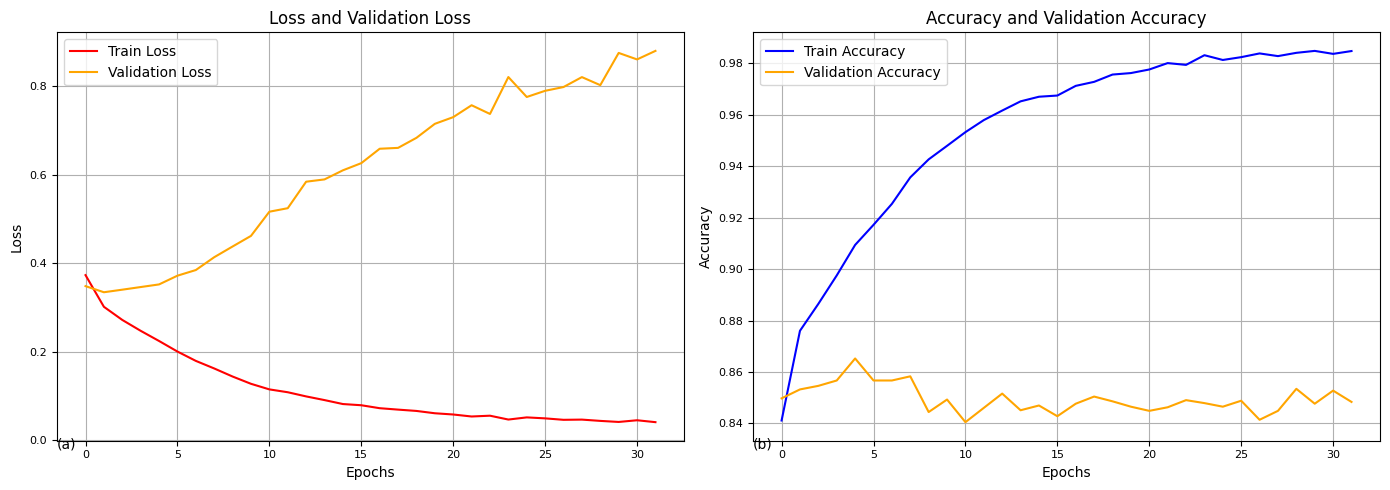

➡️ Val Accuracy: 0.8532 | Val Loss: 0.3344

🔎 Eksperimen 11/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 40


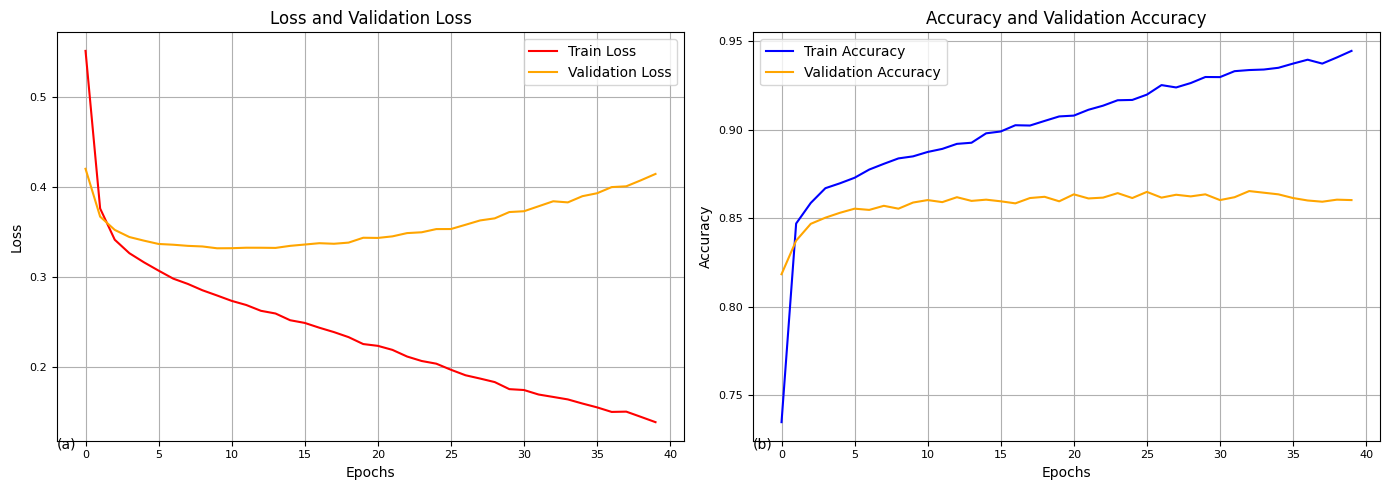

➡️ Val Accuracy: 0.8588 | Val Loss: 0.3319

🔎 Eksperimen 12/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.001}
⛔ Early stopping at epoch 43


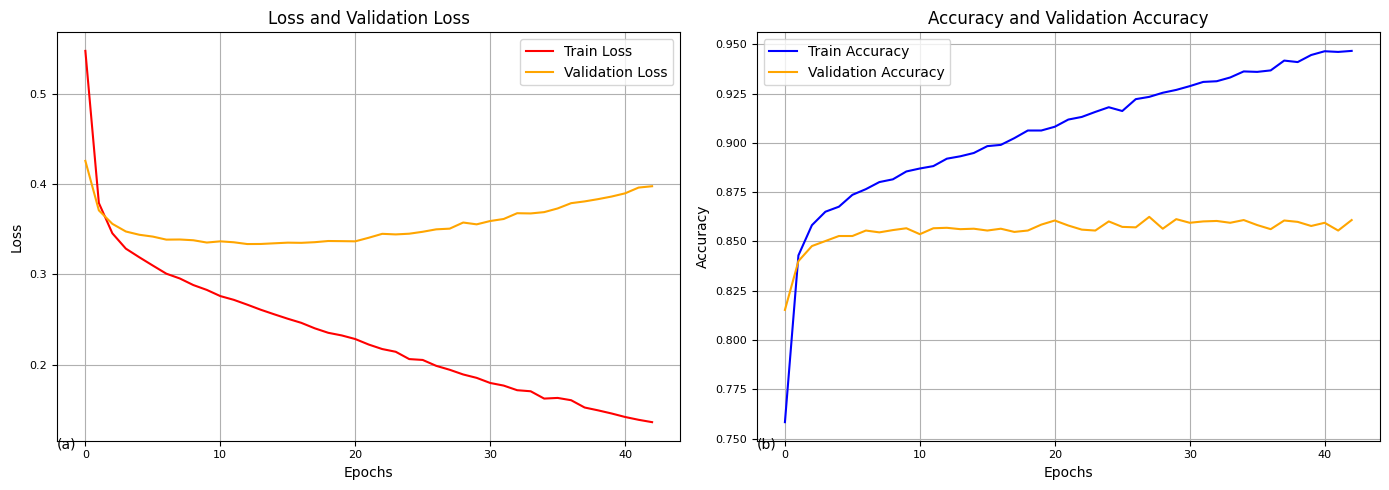

➡️ Val Accuracy: 0.8569 | Val Loss: 0.3336

🔎 Eksperimen 13/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.001}
⛔ Early stopping at epoch 39


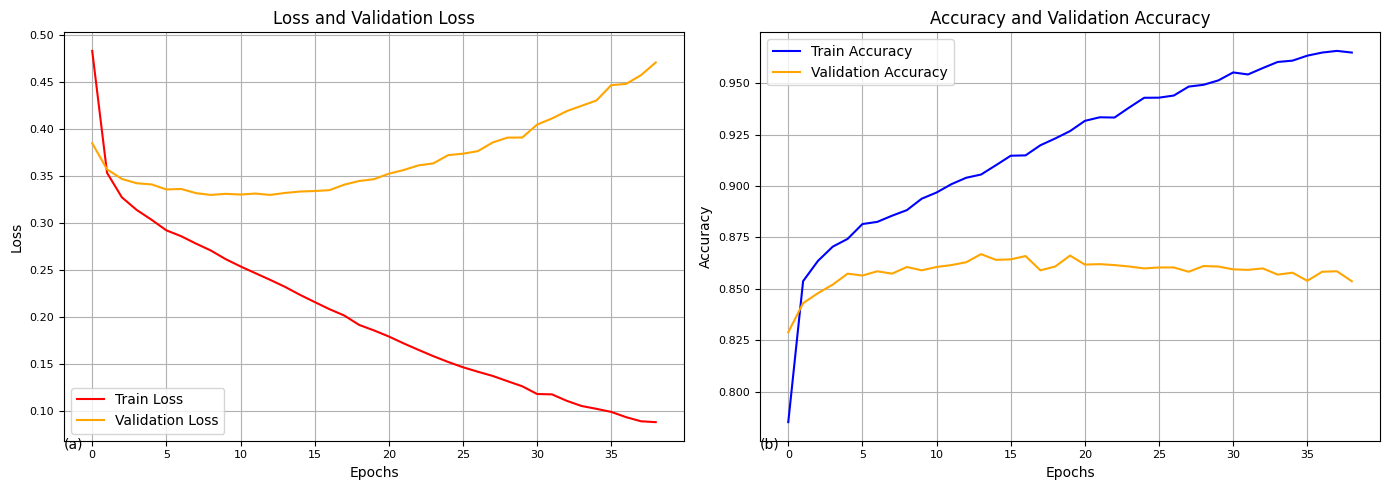

➡️ Val Accuracy: 0.8606 | Val Loss: 0.3299

🔎 Eksperimen 14/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.001}
⛔ Early stopping at epoch 35


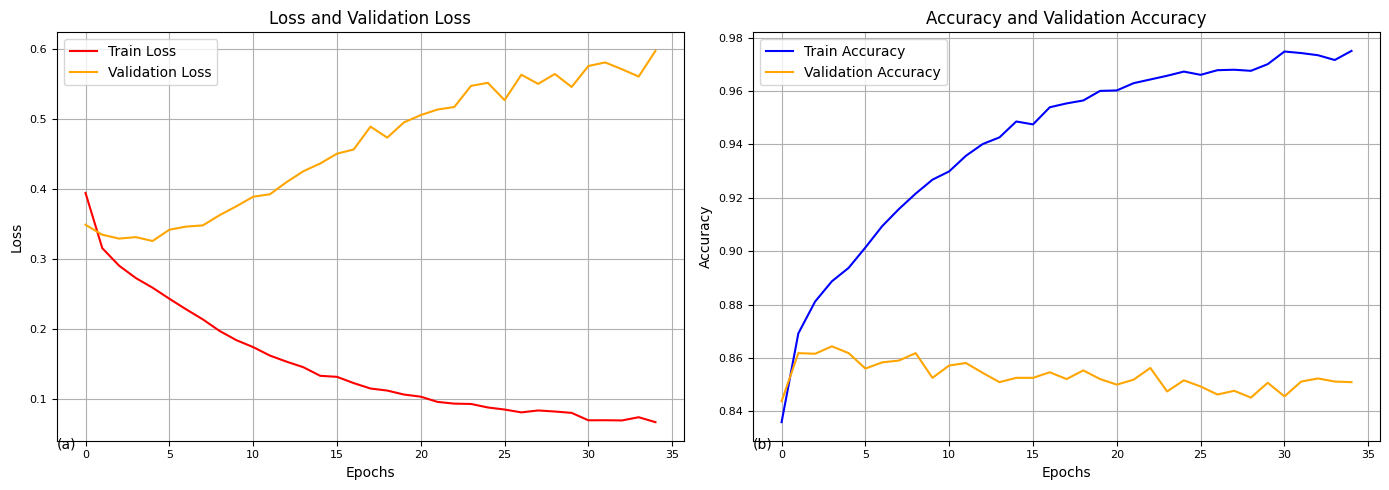

➡️ Val Accuracy: 0.8618 | Val Loss: 0.3253

🔎 Eksperimen 15/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.001}
⛔ Early stopping at epoch 35


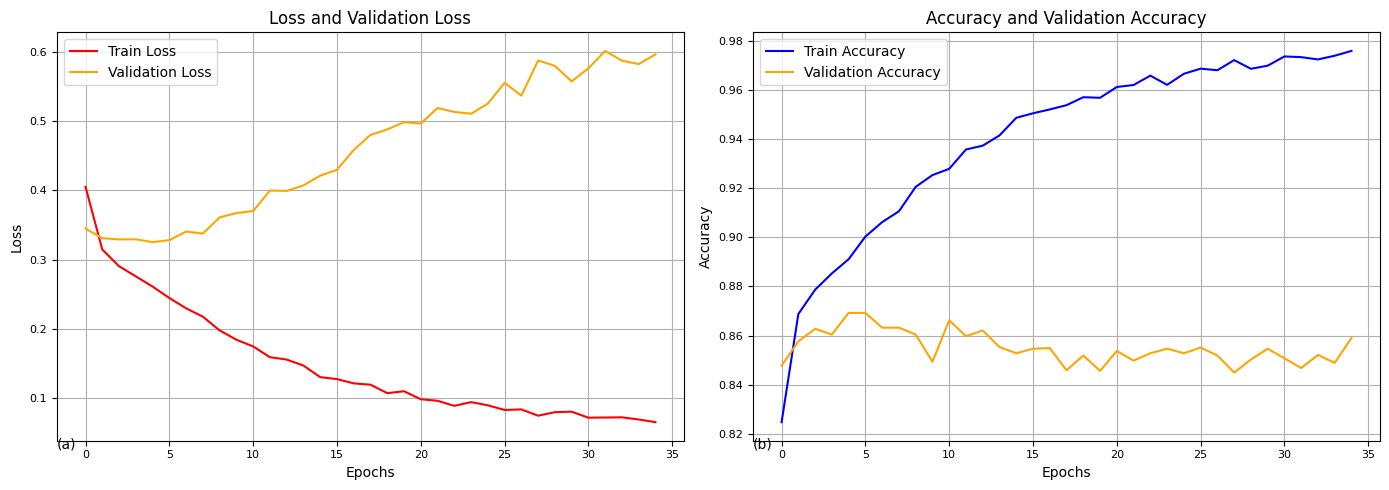

➡️ Val Accuracy: 0.8692 | Val Loss: 0.3253

🔎 Eksperimen 16/20: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.0, 'weight_decay': 0.0001}
⛔ Early stopping at epoch 32


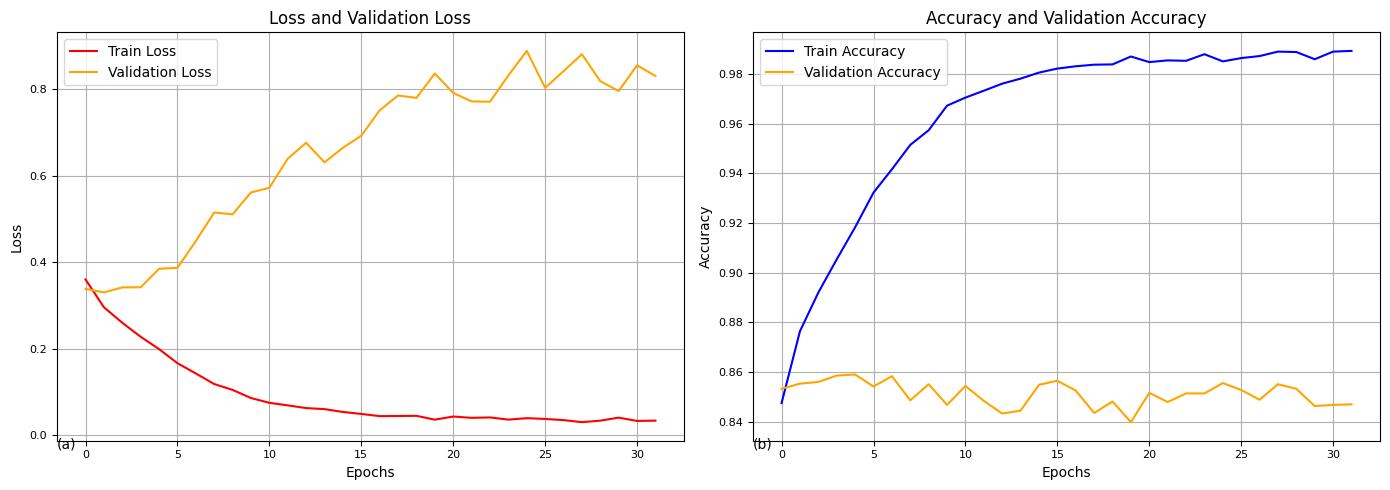

➡️ Val Accuracy: 0.8553 | Val Loss: 0.3305

🔎 Eksperimen 17/20: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.6, 'weight_decay': 0.001}
⛔ Early stopping at epoch 33


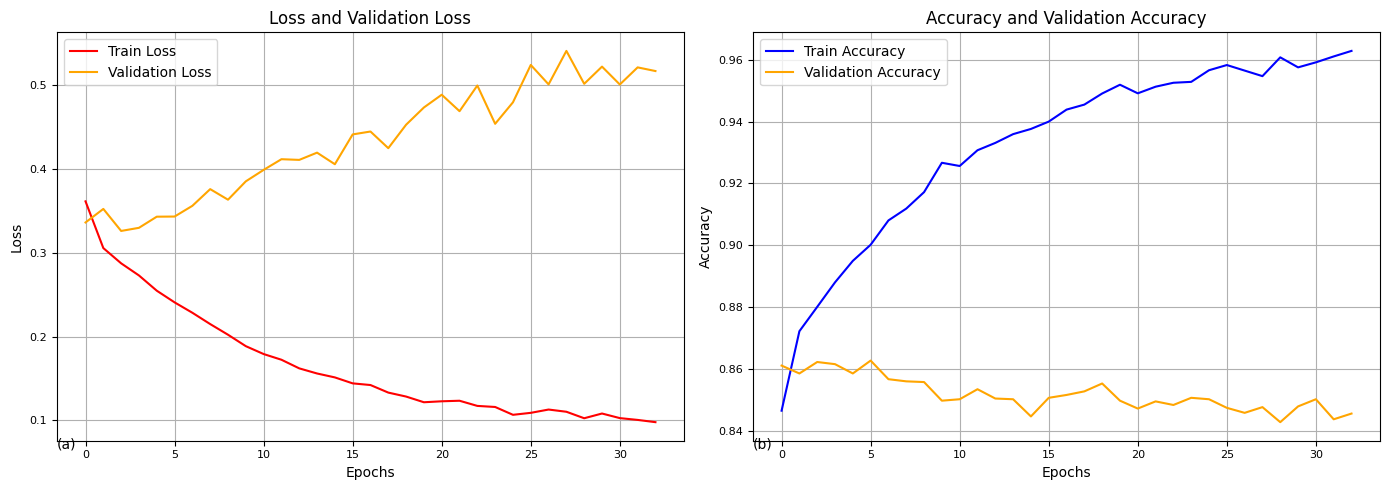

➡️ Val Accuracy: 0.8623 | Val Loss: 0.3261

🔎 Eksperimen 18/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.0, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 33


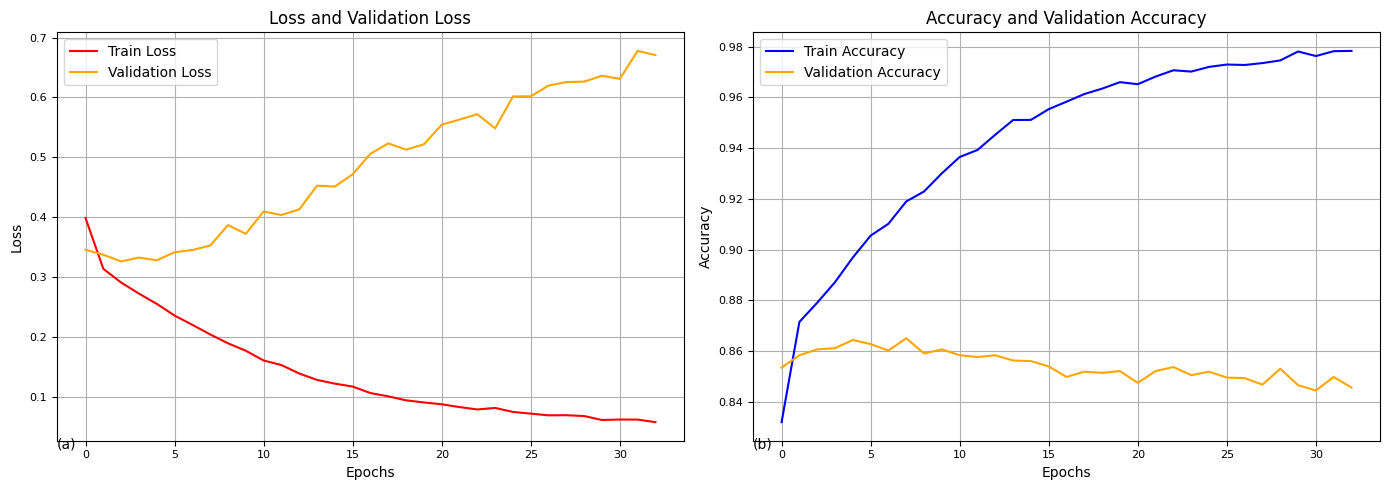

➡️ Val Accuracy: 0.8606 | Val Loss: 0.3263

🔎 Eksperimen 19/20: {'lr': 0.001, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.001}
⛔ Early stopping at epoch 32


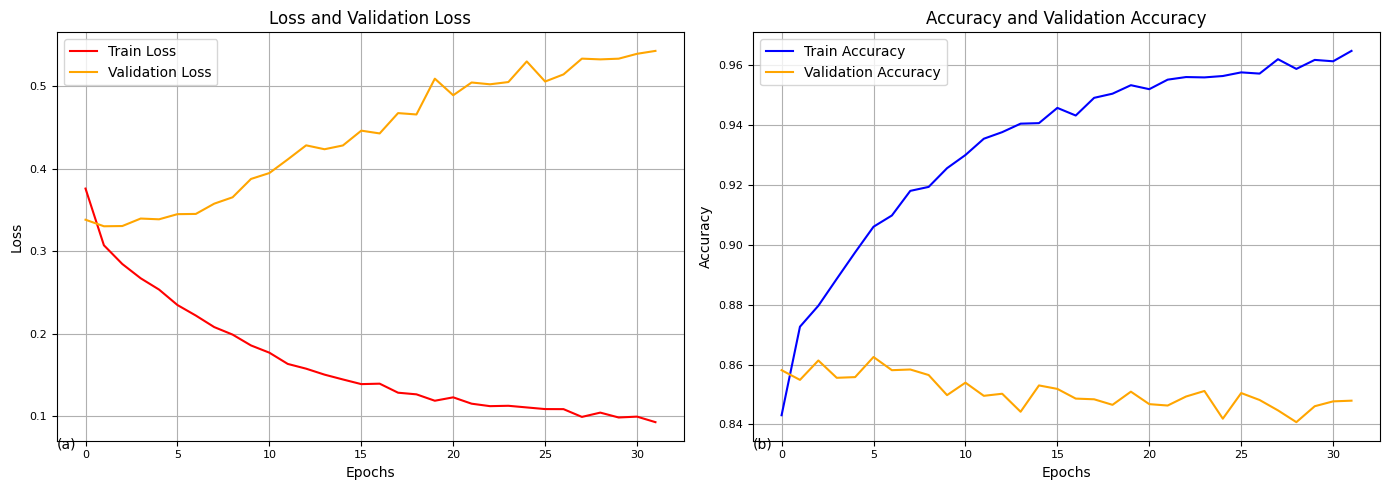

➡️ Val Accuracy: 0.8549 | Val Loss: 0.3302

🔎 Eksperimen 20/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 34


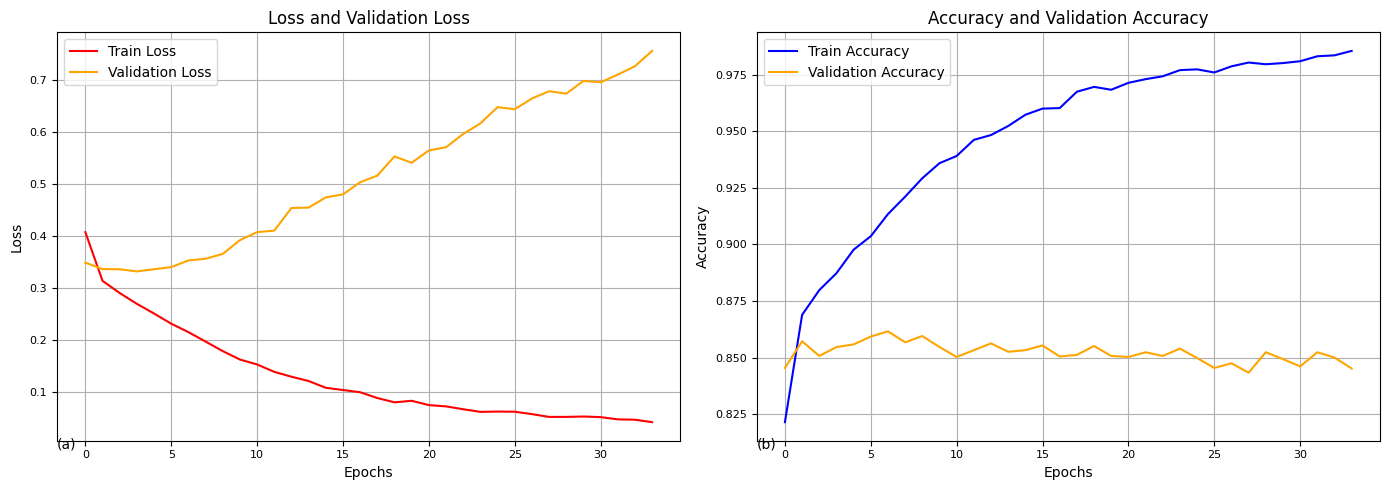

➡️ Val Accuracy: 0.8546 | Val Loss: 0.3321

✅ Best Accuracy (Val): 0.8692129629629629
📌 Best Hyperparameters: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.001}
🧪 Test Accuracy: 0.895
💾 Model terbaik disimpan ke 'gcn_cnn_cm_90_10.pth'
💾 Hasil eksperimen disimpan ke 'hyperparam_search_results.csv'


In [9]:
import random
import numpy as np
import torch
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fungsi untuk set semua seed agar eksperimen bisa diulang
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)  # Panggil fungsi seed di awal

for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === RANDOM SEARCH === #
keys, values = zip(*param_grid.items())
all_possible = list(product(*values))
num_samples = min(20, len(all_possible))
sampled_combinations = random.sample(all_possible, num_samples)
all_combinations = [dict(zip(keys, v)) for v in sampled_combinations]

best_acc = 0
best_params = None
best_model = None
results = []

for i, params in enumerate(all_combinations):
    print(f"\n🔎 Eksperimen {i+1}/{num_samples}: {params}")

    # Train GCN dengan early stopping dan validasi
    val_acc, val_loss, model = train_gcn_once(
        params,
        train_loader,
        val_loader,
        in_channels,
        num_classes=2,
        use_early_stopping=True  # pastikan kamu support ini di fungsimu
    )

    print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    results.append({
        'experiment': i + 1,
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

# === TEST EVALUATION === #
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Best Accuracy (Val):", best_acc)
print("📌 Best Hyperparameters:", best_params)
print("🧪 Test Accuracy:", test_acc)
# Simpan model terbaik
model_path = "gcn_cnn_cm_90_10.pth"
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model terbaik disimpan ke '{model_path}'")

# Simpan hasil ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("hyperparam_search_results.csv", index=False)
print("💾 Hasil eksperimen disimpan ke 'hyperparam_search_results.csv'")


In [10]:
from sklearn.metrics import classification_report

# === TEST EVALUATION DENGAN CLASSIFICATION REPORT === #
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
print("\n📋 Classification Report di Test Set:")
print(classification_report(true_labels, pred_labels, digits=4))



📋 Classification Report di Test Set:
              precision    recall  f1-score   support

           0     0.8655    0.9100    0.8872      1089
           1     0.9219    0.8825    0.9018      1311

    accuracy                         0.8950      2400
   macro avg     0.8937    0.8963    0.8945      2400
weighted avg     0.8963    0.8950    0.8952      2400




📊 Evaluasi Model pada Data Uji
✅ Accuracy   : 0.8950
✅ F1 Score   : 0.9018
✅ Recall     : 0.8825
✅ Precision  : 0.9219

🧩 Confusion Matrix:
 [[ 991   98]
 [ 154 1157]]


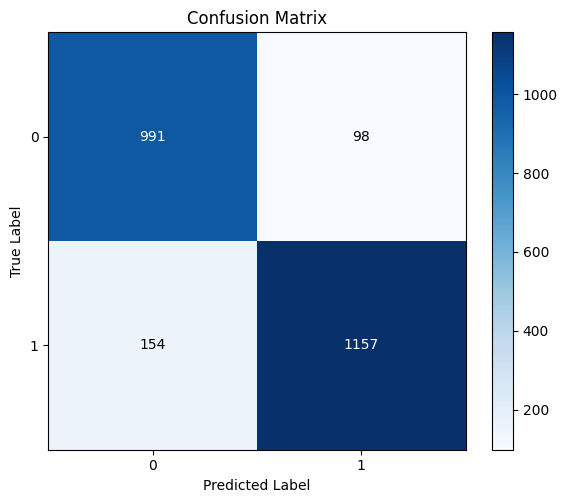


❌ Jumlah prediksi salah: 252
📄 Log kesalahan disimpan ke: wrong_predictions.csv


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import os

# === Evaluasi Model Terbaik === #
best_model.eval()
all_preds, all_labels, all_scores, all_file_names = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_scores.extend(probs.tolist())
        all_file_names.extend(file_names)

# === Hitung Metrik === #
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Evaluasi Model pada Data Uji")
print("=" * 40)
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print(f"✅ Recall     : {recall:.4f}")
print(f"✅ Precision  : {precision:.4f}")
print("\n🧩 Confusion Matrix:\n", cm)
print("=" * 40)

# === Simpan ke File Teks === #
with open("test_evaluation_report.txt", "w") as f:
    f.write("📊 Evaluasi Model pada Data Uji\n")
    f.write("=" * 40 + "\n")
    f.write(f"Accuracy   : {acc:.4f}\n")
    f.write(f"F1 Score   : {f1:.4f}\n")
    f.write(f"Recall     : {recall:.4f}\n")
    f.write(f"Precision  : {precision:.4f}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm) + "\n")
    f.write("=" * 40 + "\n")

# === Gambar Confusion Matrix === #
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()

# === Simpan Prediksi yang Salah === #
wrong_preds = []
for fname, pred, label, score in zip(all_file_names, all_preds, all_labels, all_scores):
    if pred != label:
        wrong_preds.append({
            'file_name': fname,
            'true_label': label,
            'predicted_label': pred,
            'score_0': score[0],
            'score_1': score[1],
        })

wrong_log_path = "wrong_predictions.csv"
with open(wrong_log_path, mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['file_name', 'true_label', 'predicted_label', 'score_0', 'score_1'])
    writer.writeheader()
    for row in wrong_preds:
        writer.writerow(row)

print(f"\n❌ Jumlah prediksi salah: {len(wrong_preds)}")
print(f"📄 Log kesalahan disimpan ke: {wrong_log_path}")


80 20


🔎 Eksperimen 1/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.6, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 38


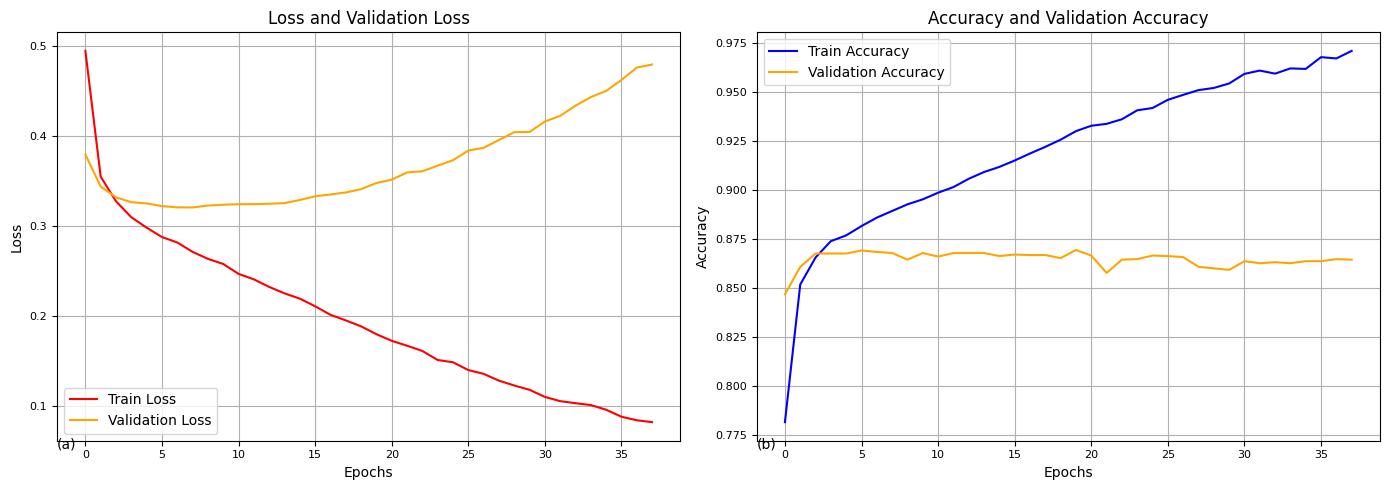

➡️ Val Accuracy: 0.8680 | Val Loss: 0.3206

🔎 Eksperimen 2/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 45


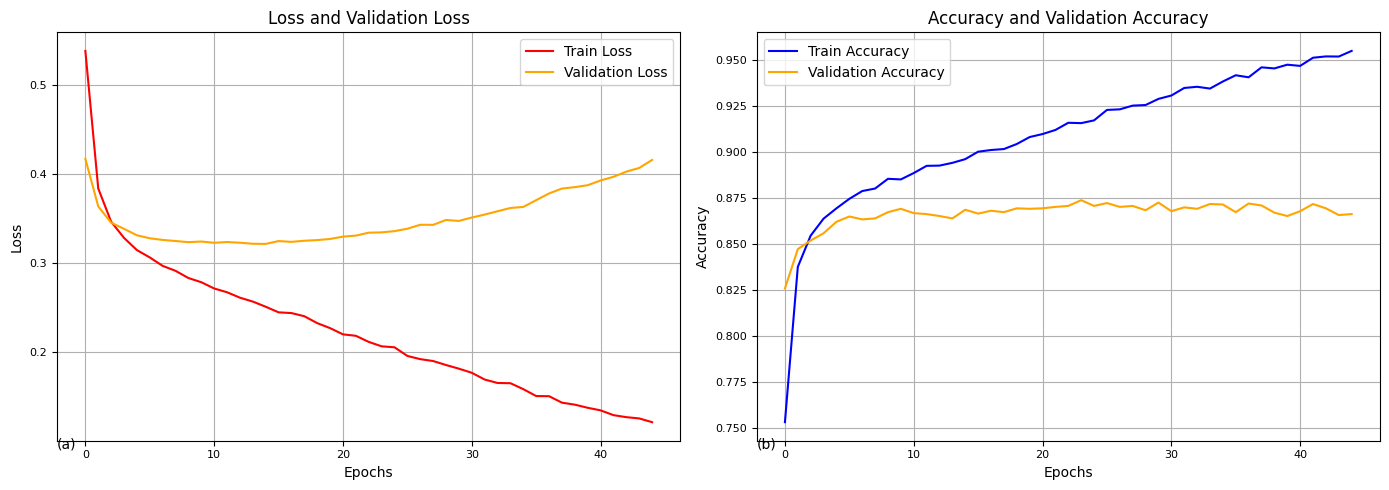

➡️ Val Accuracy: 0.8685 | Val Loss: 0.3217

🔎 Eksperimen 3/20: {'lr': 0.0005, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 33


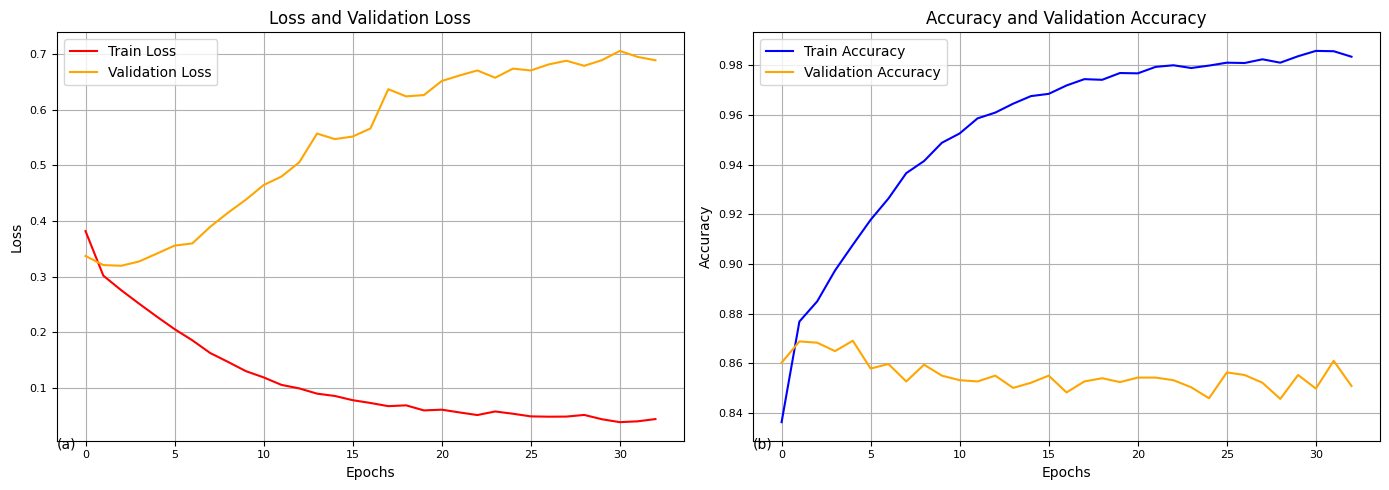

➡️ Val Accuracy: 0.8682 | Val Loss: 0.3198

🔎 Eksperimen 4/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.6, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 33


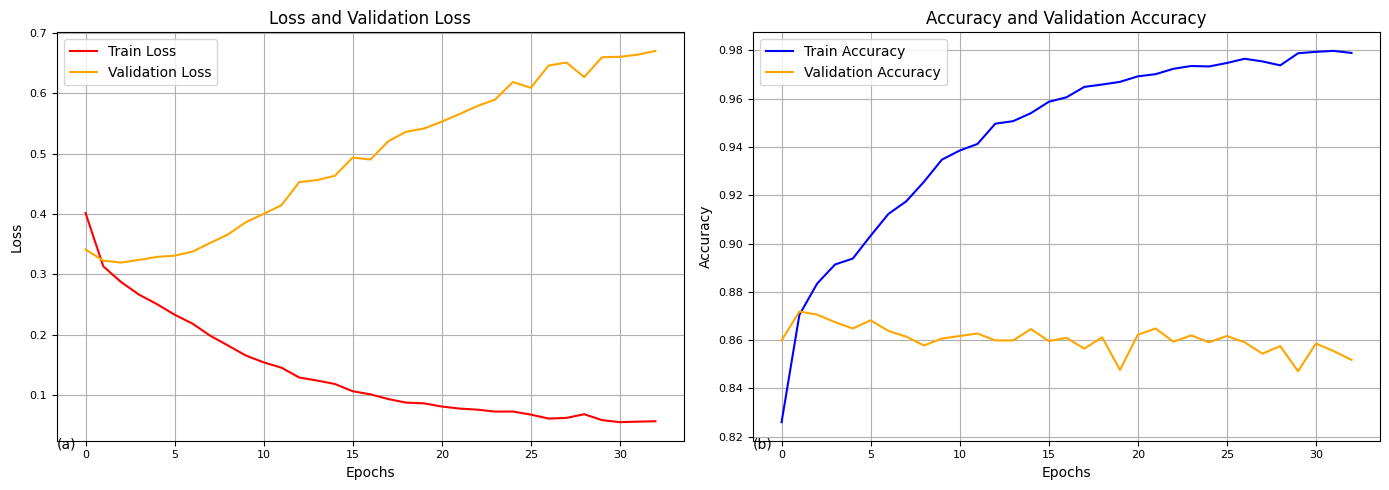

➡️ Val Accuracy: 0.8706 | Val Loss: 0.3197

🔎 Eksperimen 5/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.0001}
⛔ Early stopping at epoch 34


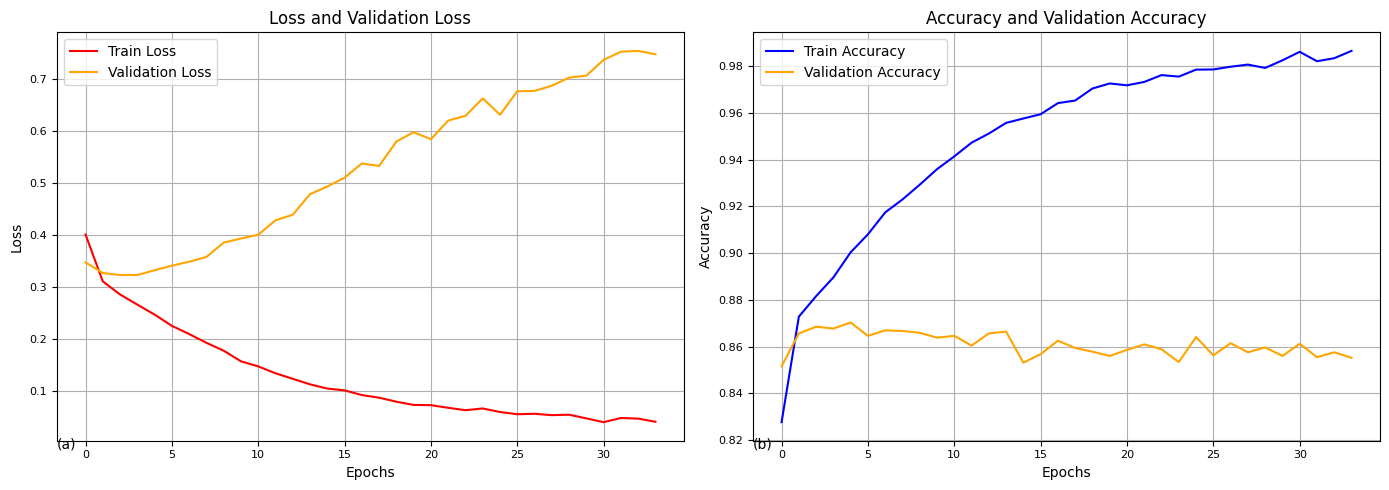

➡️ Val Accuracy: 0.8677 | Val Loss: 0.3227

🔎 Eksperimen 6/20: {'lr': 0.0001, 'hidden_channels': 256, 'dropout': 0.0, 'weight_decay': 0.001}
⛔ Early stopping at epoch 36


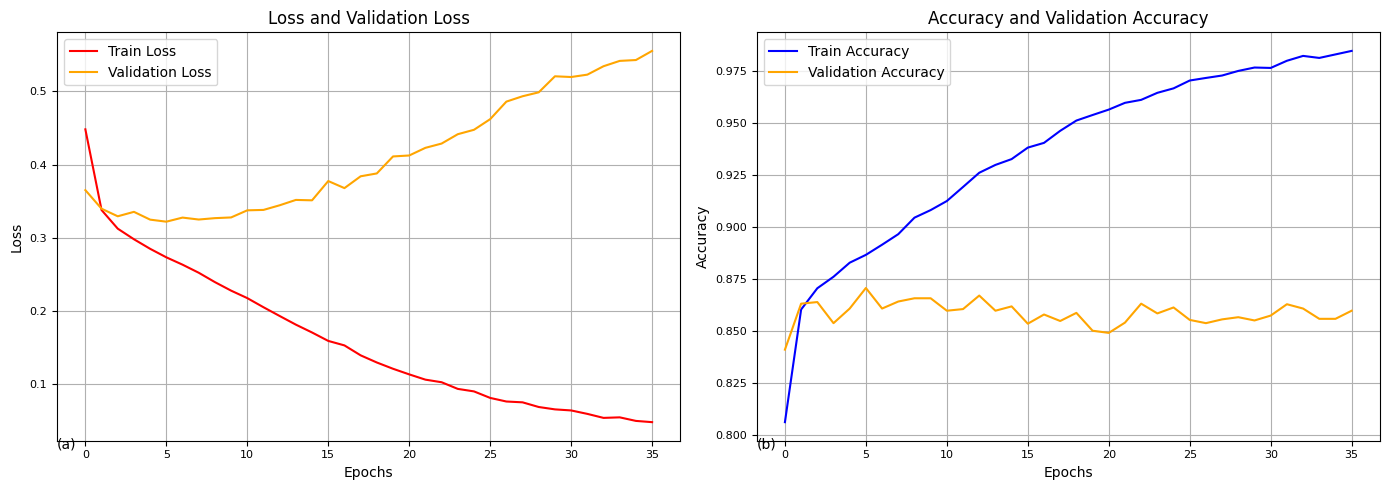

➡️ Val Accuracy: 0.8706 | Val Loss: 0.3218

🔎 Eksperimen 7/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.4, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 38


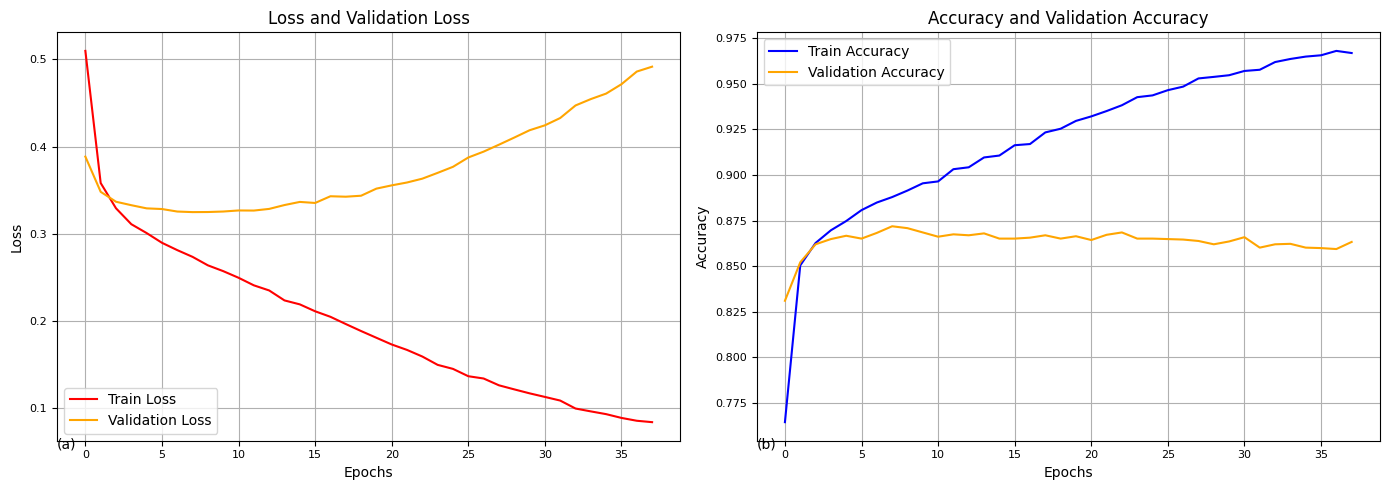

➡️ Val Accuracy: 0.8719 | Val Loss: 0.3248

🔎 Eksperimen 8/20: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.4, 'weight_decay': 0.001}
⛔ Early stopping at epoch 33


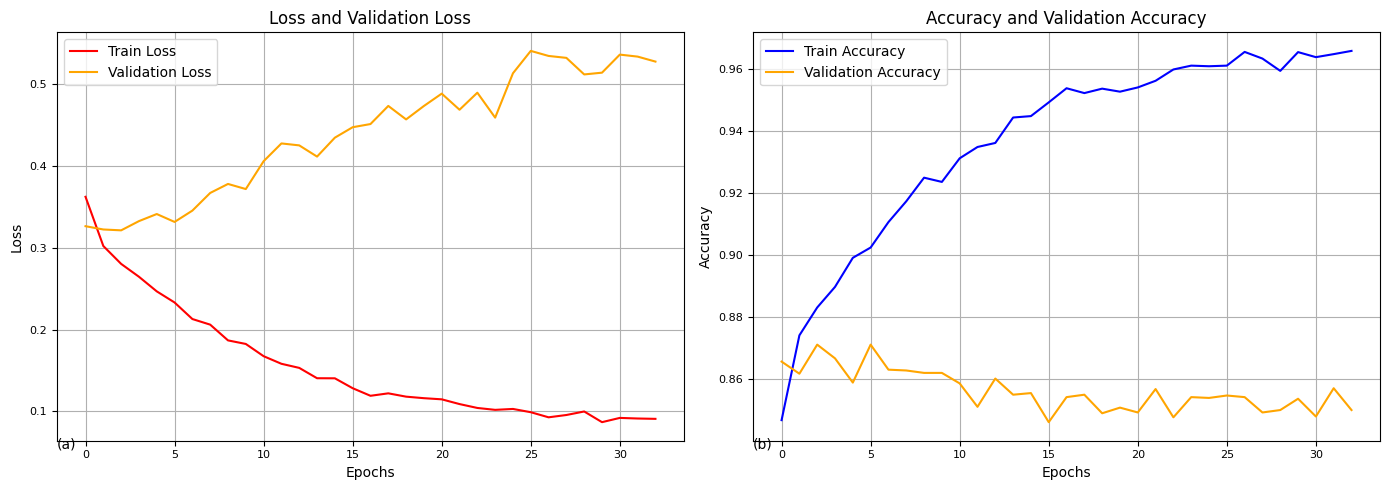

➡️ Val Accuracy: 0.8711 | Val Loss: 0.3215

🔎 Eksperimen 9/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 37


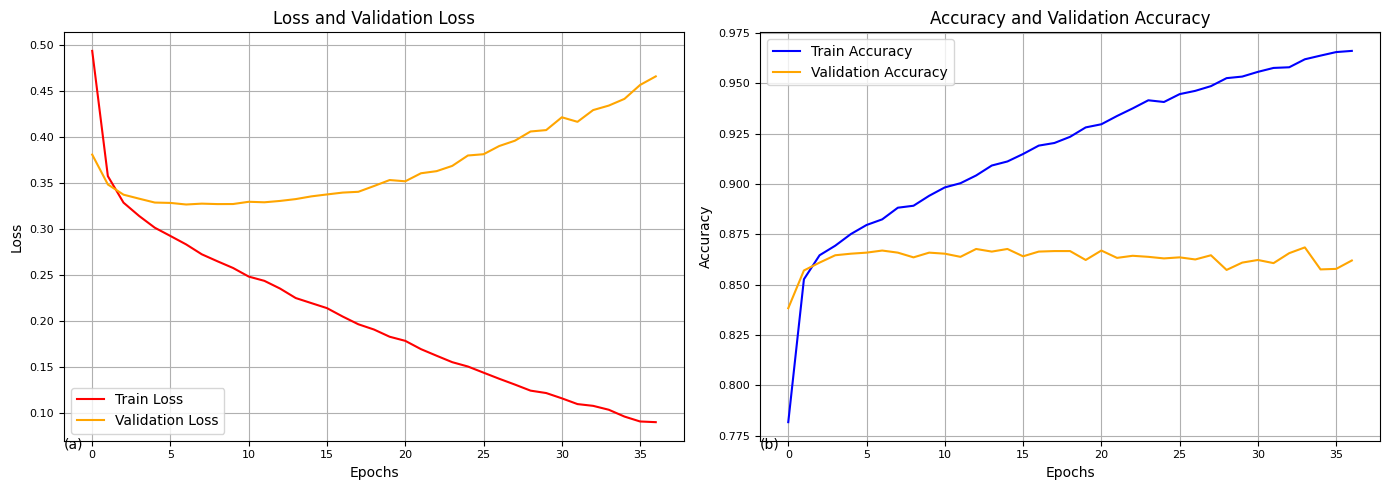

➡️ Val Accuracy: 0.8669 | Val Loss: 0.3266

🔎 Eksperimen 10/20: {'lr': 0.001, 'hidden_channels': 64, 'dropout': 0.6, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 32


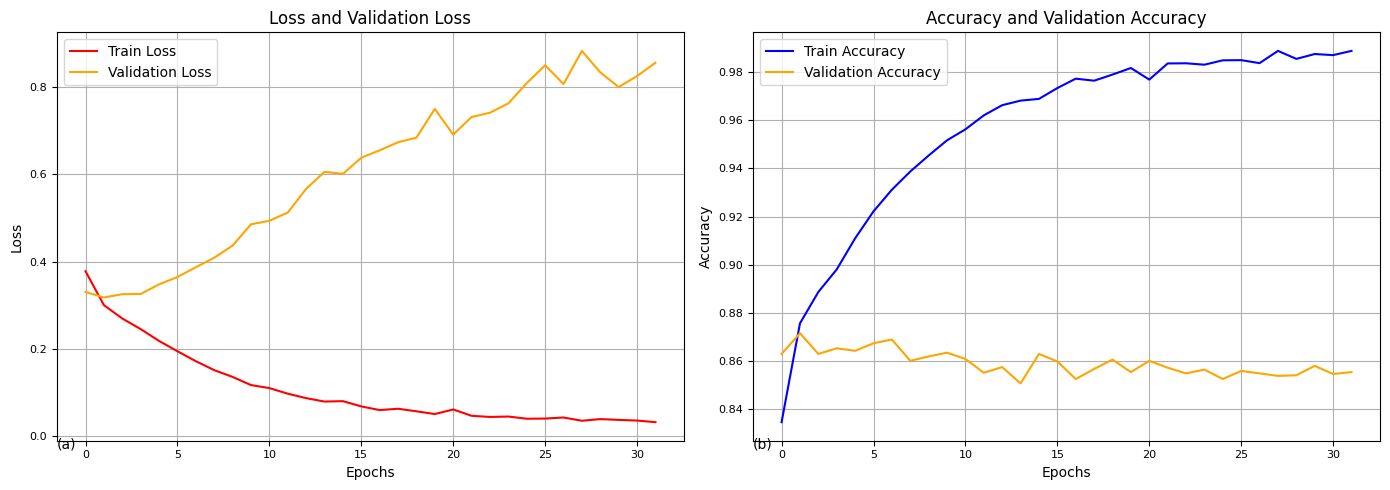

➡️ Val Accuracy: 0.8716 | Val Loss: 0.3179

🔎 Eksperimen 11/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 41


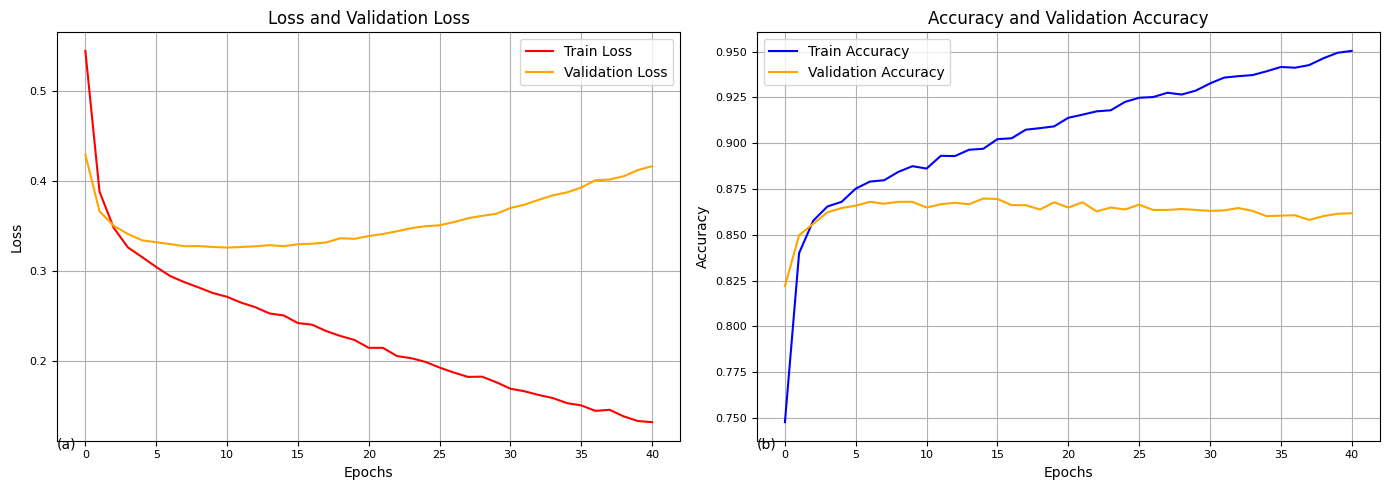

➡️ Val Accuracy: 0.8648 | Val Loss: 0.3262

🔎 Eksperimen 12/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.001}
⛔ Early stopping at epoch 45


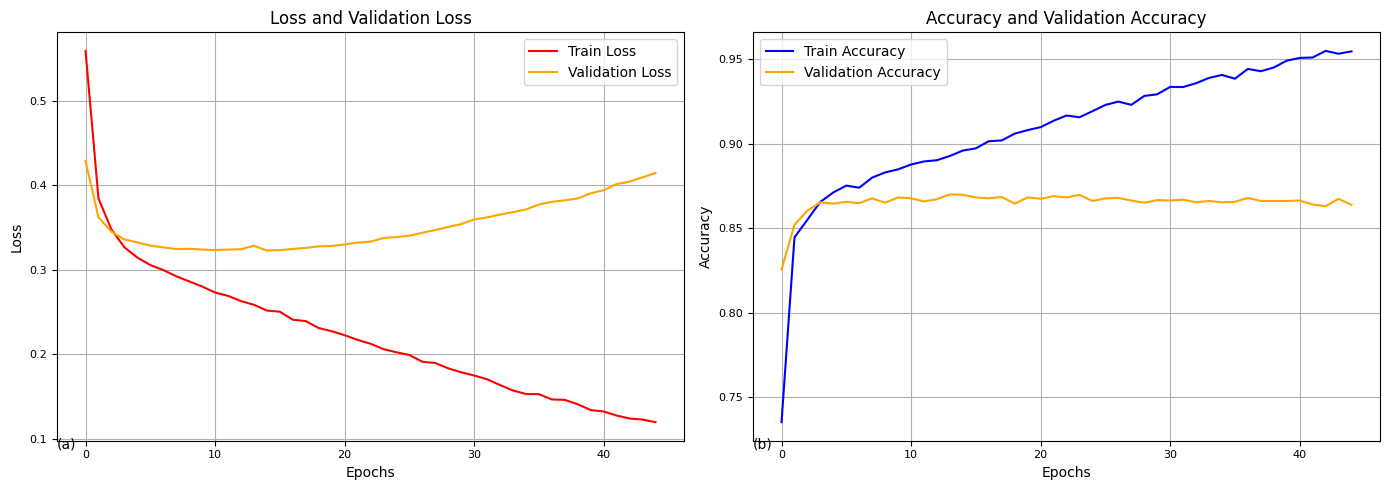

➡️ Val Accuracy: 0.8698 | Val Loss: 0.3229

🔎 Eksperimen 13/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.001}
⛔ Early stopping at epoch 41


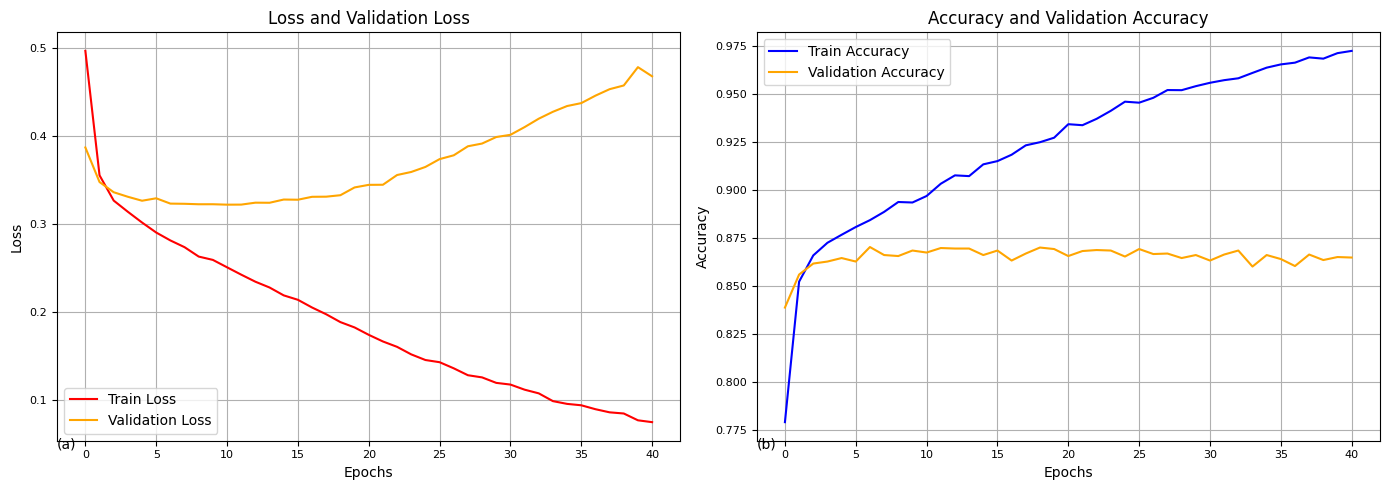

➡️ Val Accuracy: 0.8674 | Val Loss: 0.3219

🔎 Eksperimen 14/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.001}
⛔ Early stopping at epoch 34


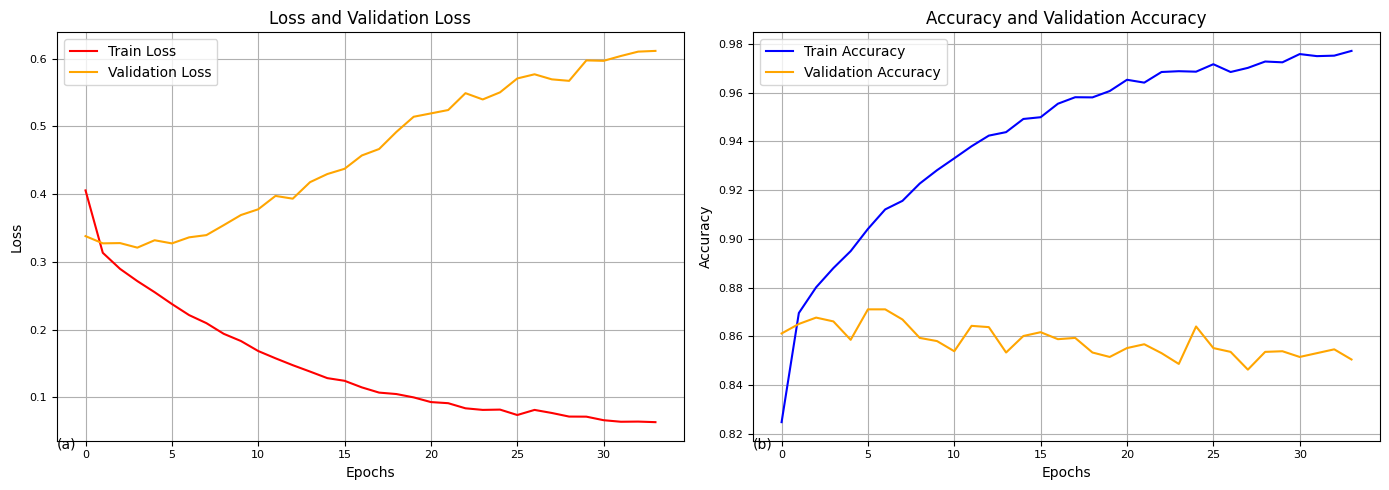

➡️ Val Accuracy: 0.8661 | Val Loss: 0.3209

🔎 Eksperimen 15/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.001}
⛔ Early stopping at epoch 33


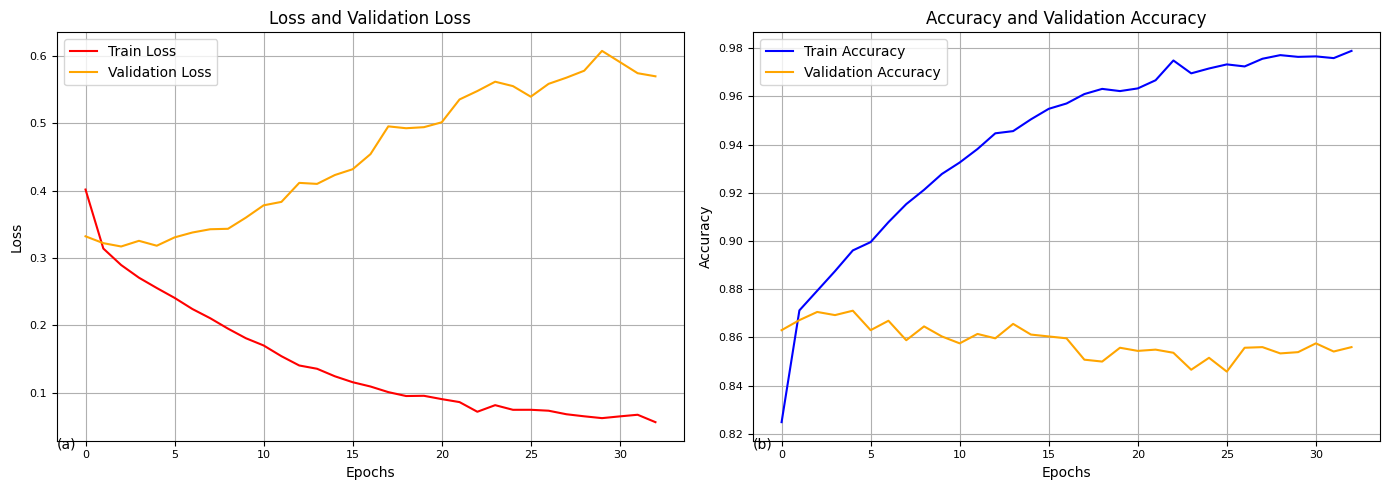

➡️ Val Accuracy: 0.8706 | Val Loss: 0.3173

🔎 Eksperimen 16/20: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.0, 'weight_decay': 0.0001}
⛔ Early stopping at epoch 32


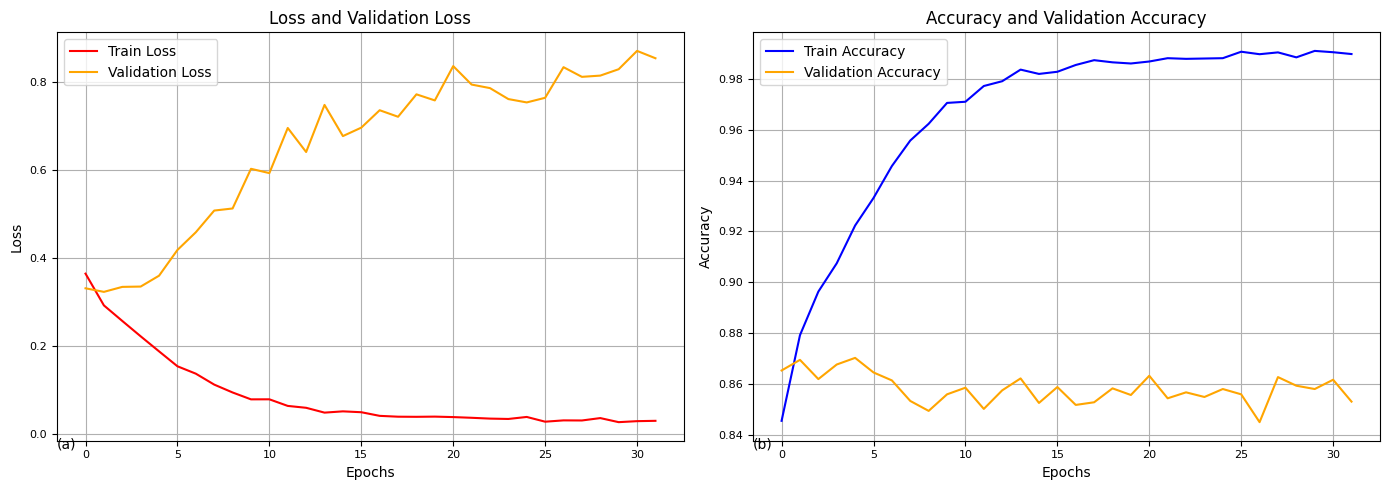

➡️ Val Accuracy: 0.8695 | Val Loss: 0.3225

🔎 Eksperimen 17/20: {'lr': 0.001, 'hidden_channels': 256, 'dropout': 0.6, 'weight_decay': 0.001}
⛔ Early stopping at epoch 32


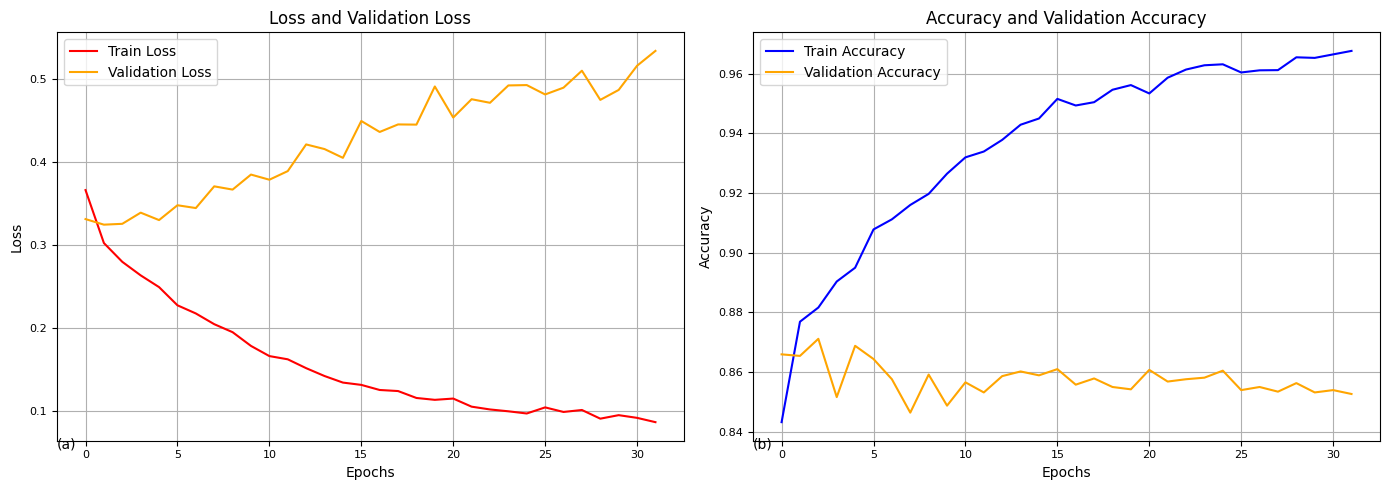

➡️ Val Accuracy: 0.8654 | Val Loss: 0.3239

🔎 Eksperimen 18/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.0, 'weight_decay': 0.0005}
⛔ Early stopping at epoch 34


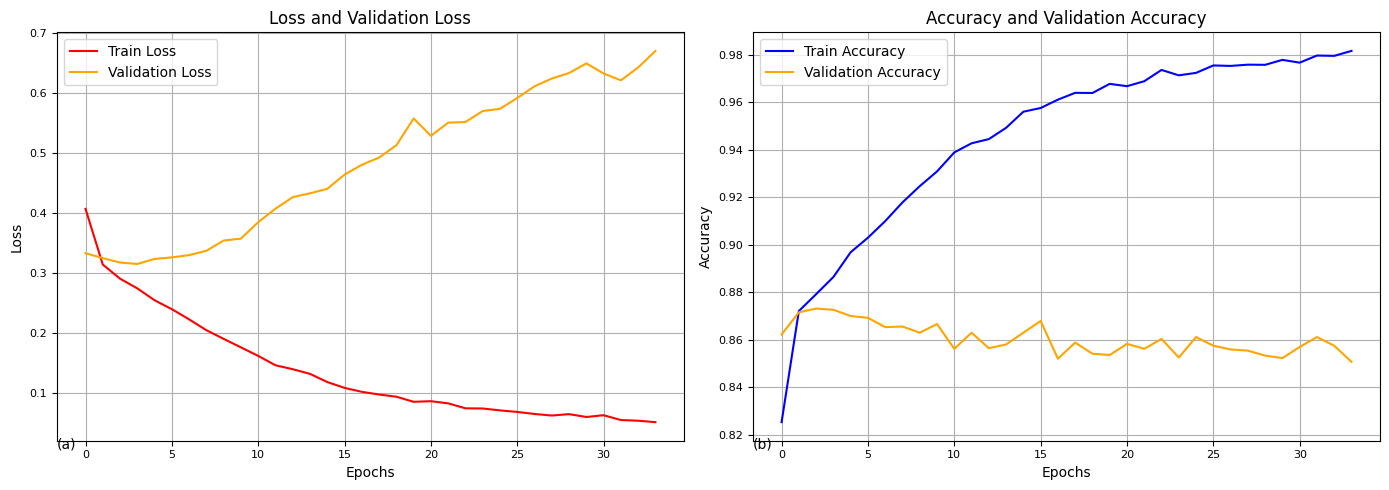

➡️ Val Accuracy: 0.8727 | Val Loss: 0.3149

🔎 Eksperimen 19/20: {'lr': 0.001, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 0.001}
⛔ Early stopping at epoch 33


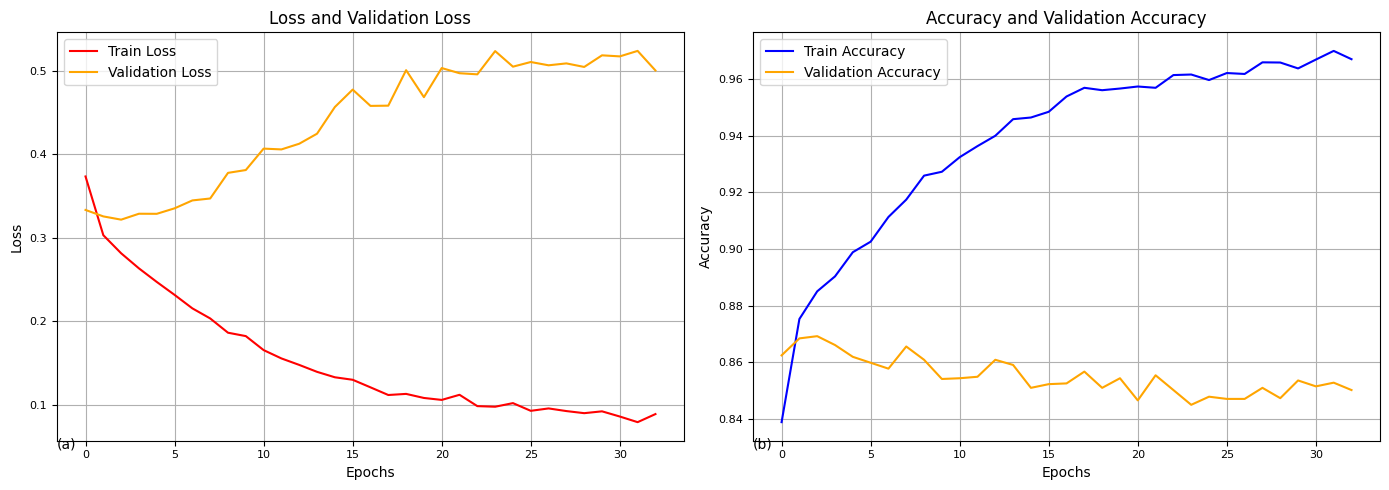

➡️ Val Accuracy: 0.8693 | Val Loss: 0.3218

🔎 Eksperimen 20/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.4, 'weight_decay': 1e-05}
⛔ Early stopping at epoch 33


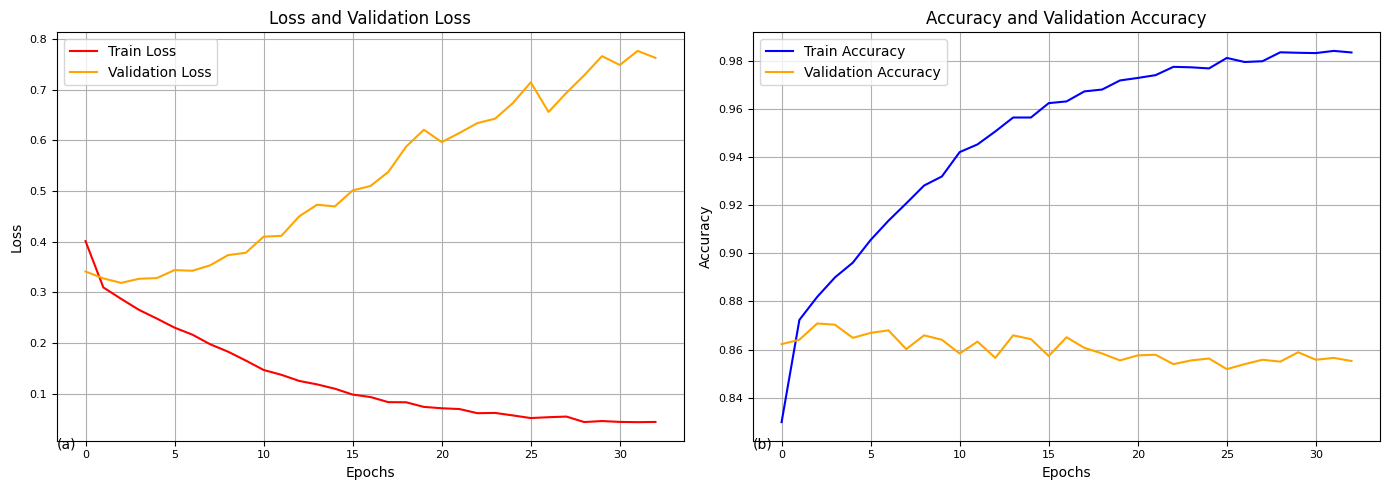

➡️ Val Accuracy: 0.8708 | Val Loss: 0.3186

✅ Best Accuracy (Val): 0.87265625
📌 Best Hyperparameters: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.0, 'weight_decay': 0.0005}
🧪 Test Accuracy: 0.870625
💾 Model terbaik disimpan ke 'gcn_cnn_cm_80_20.pth'
💾 Hasil eksperimen disimpan ke 'hyperparam_search_results.csv'


In [10]:
import random
import numpy as np
import torch
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fungsi untuk set semua seed agar eksperimen bisa diulang
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)  # Panggil fungsi seed di awal

for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === RANDOM SEARCH === #
keys, values = zip(*param_grid.items())
all_possible = list(product(*values))
num_samples = min(20, len(all_possible))
sampled_combinations = random.sample(all_possible, num_samples)
all_combinations = [dict(zip(keys, v)) for v in sampled_combinations]

best_acc = 0
best_params = None
best_model = None
results = []

for i, params in enumerate(all_combinations):
    print(f"\n🔎 Eksperimen {i+1}/{num_samples}: {params}")

    # Train GCN dengan early stopping dan validasi
    val_acc, val_loss, model = train_gcn_once(
        params,
        train_loader,
        val_loader,
        in_channels,
        num_classes=2,
        use_early_stopping=True  # pastikan kamu support ini di fungsimu
    )

    print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    results.append({
        'experiment': i + 1,
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

# === TEST EVALUATION === #
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Best Accuracy (Val):", best_acc)
print("📌 Best Hyperparameters:", best_params)
print("🧪 Test Accuracy:", test_acc)
# Simpan model terbaik
model_path = "gcn_cnn_cm_80_20.pth"
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model terbaik disimpan ke '{model_path}'")

# Simpan hasil ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("hyperparam_search_results.csv", index=False)
print("💾 Hasil eksperimen disimpan ke 'hyperparam_search_results.csv'")


In [11]:
from sklearn.metrics import classification_report

# === TEST EVALUATION DENGAN CLASSIFICATION REPORT === #
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
print("\n📋 Classification Report di Test Set:")
print(classification_report(true_labels, pred_labels, digits=4))



📋 Classification Report di Test Set:
              precision    recall  f1-score   support

           0     0.8706    0.8353    0.8526      2150
           1     0.8707    0.8992    0.8847      2650

    accuracy                         0.8706      4800
   macro avg     0.8706    0.8673    0.8687      4800
weighted avg     0.8706    0.8706    0.8703      4800




📊 Evaluasi Model pada Data Uji
✅ Accuracy   : 0.8706
✅ F1 Score   : 0.8847
✅ Recall     : 0.8992
✅ Precision  : 0.8707

🧩 Confusion Matrix:
 [[1796  354]
 [ 267 2383]]


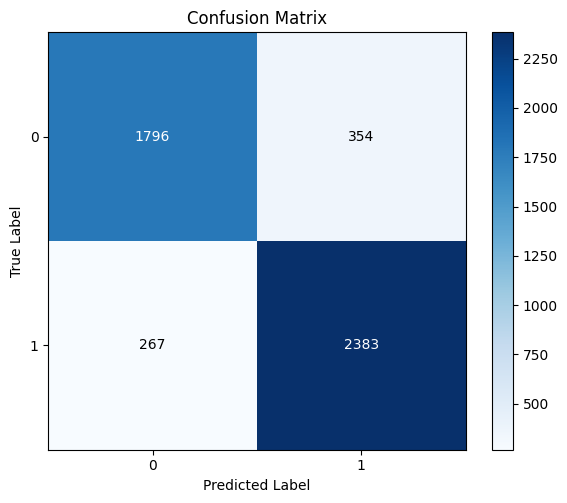


❌ Jumlah prediksi salah: 621
📄 Log kesalahan disimpan ke: wrong_predictions.csv


In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import os

# === Evaluasi Model Terbaik === #
best_model.eval()
all_preds, all_labels, all_scores, all_file_names = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_scores.extend(probs.tolist())
        all_file_names.extend(file_names)

# === Hitung Metrik === #
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Evaluasi Model pada Data Uji")
print("=" * 40)
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print(f"✅ Recall     : {recall:.4f}")
print(f"✅ Precision  : {precision:.4f}")
print("\n🧩 Confusion Matrix:\n", cm)
print("=" * 40)

# === Simpan ke File Teks === #
with open("test_evaluation_report.txt", "w") as f:
    f.write("📊 Evaluasi Model pada Data Uji\n")
    f.write("=" * 40 + "\n")
    f.write(f"Accuracy   : {acc:.4f}\n")
    f.write(f"F1 Score   : {f1:.4f}\n")
    f.write(f"Recall     : {recall:.4f}\n")
    f.write(f"Precision  : {precision:.4f}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm) + "\n")
    f.write("=" * 40 + "\n")

# === Gambar Confusion Matrix === #
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()

# === Simpan Prediksi yang Salah === #
wrong_preds = []
for fname, pred, label, score in zip(all_file_names, all_preds, all_labels, all_scores):
    if pred != label:
        wrong_preds.append({
            'file_name': fname,
            'true_label': label,
            'predicted_label': pred,
            'score_0': score[0],
            'score_1': score[1],
        })

wrong_log_path = "wrong_predictions.csv"
with open(wrong_log_path, mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['file_name', 'true_label', 'predicted_label', 'score_0', 'score_1'])
    writer.writeheader()
    for row in wrong_preds:
        writer.writerow(row)

print(f"\n❌ Jumlah prediksi salah: {len(wrong_preds)}")
print(f"📄 Log kesalahan disimpan ke: {wrong_log_path}")


In [ ]:
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [ ]:
# Pastikan class GCNGraphClassifier sudah didefinisikan sebelum ini
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ambil fitur dari data
sample = train_data[0]
in_channels = sample.num_node_features

# Inisialisasi model
model = GCNGraphClassifier(in_channels=in_channels, hidden_channels=256, num_classes=2).to(device)



In [ ]:
print(model)

GCNGraphClassifier(
  (conv1): GCNConv(512, 256)
  (conv2): GCNConv(256, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.num_graphs
            all_preds.extend(pred.cpu().tolist())
            all_labels.extend(batch.y.cpu().tolist())
    accuracy = correct / total
    return accuracy, (all_preds, all_labels)


[Epoch 1] Loss: 0.3663 | Val Loss: 0.3429 | Train Acc: 0.8815 | Val Acc: 0.8519
[Epoch 2] Loss: 0.3105 | Val Loss: 0.3360 | Train Acc: 0.8901 | Val Acc: 0.8551
[Epoch 3] Loss: 0.2928 | Val Loss: 0.3275 | Train Acc: 0.8981 | Val Acc: 0.8565
[Epoch 4] Loss: 0.2807 | Val Loss: 0.3324 | Train Acc: 0.9058 | Val Acc: 0.8593
[Epoch 5] Loss: 0.2705 | Val Loss: 0.3296 | Train Acc: 0.9089 | Val Acc: 0.8609
[Epoch 6] Loss: 0.2572 | Val Loss: 0.3349 | Train Acc: 0.9155 | Val Acc: 0.8604
[Epoch 7] Loss: 0.2468 | Val Loss: 0.3359 | Train Acc: 0.9192 | Val Acc: 0.8579
[Epoch 8] Loss: 0.2378 | Val Loss: 0.3433 | Train Acc: 0.9255 | Val Acc: 0.8551
[Epoch 9] Loss: 0.2272 | Val Loss: 0.3513 | Train Acc: 0.9312 | Val Acc: 0.8523
[Epoch 10] Loss: 0.2188 | Val Loss: 0.3510 | Train Acc: 0.9390 | Val Acc: 0.8581
[Epoch 11] Loss: 0.2093 | Val Loss: 0.3543 | Train Acc: 0.9378 | Val Acc: 0.8565
[Epoch 12] Loss: 0.1994 | Val Loss: 0.3710 | Train Acc: 0.9431 | Val Acc: 0.8551
[Epoch 13] Loss: 0.1952 | Val Loss: 0

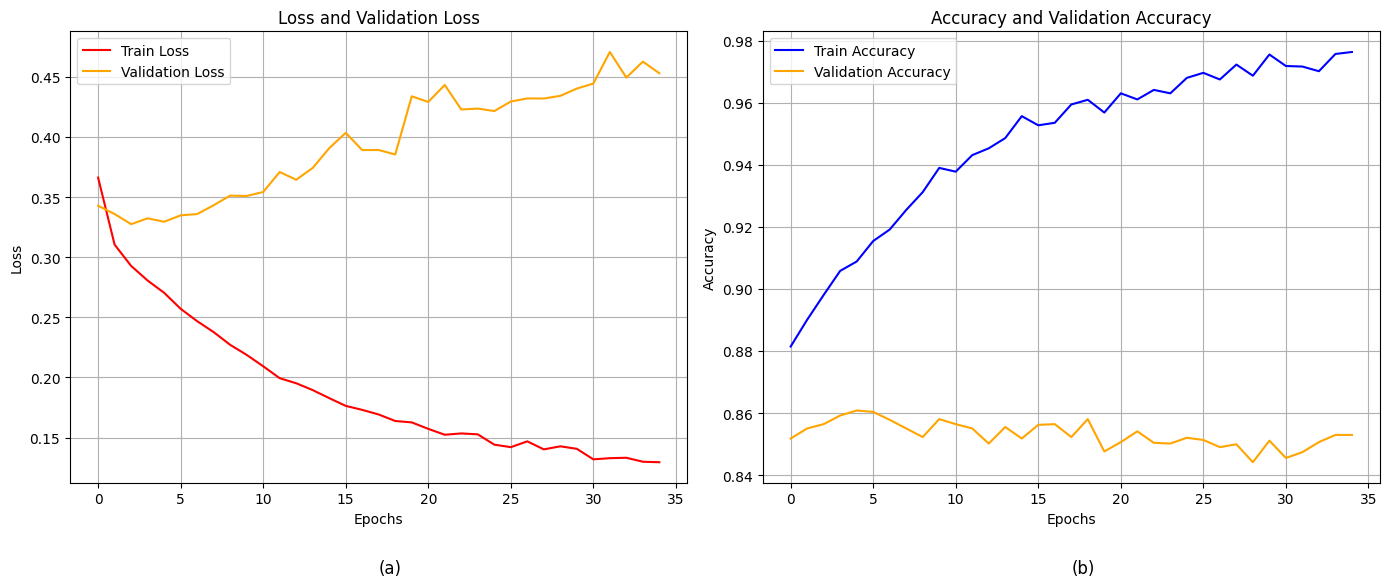

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# ⚙️ Konfigurasi awal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚖️ Class weight (ubah sesuai kebutuhan)
class_weights = torch.tensor([1.097, 0.919], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

# 📊 Penyimpanan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 30
epochs_without_improvement = 0

# 🔁 Training loop
for epoch in range(1, 301):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔹 Hitung akurasi training
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🔸 Hitung akurasi dan loss validasi
    val_preds, val_labels = [], []
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss_total += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch}] Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch}")
        break

# 💾 Simpan model terbaik
if best_model_state:
    torch.save(best_model_state, "best_model_gcn.pth")
    print("📦 Model terbaik disimpan ke 'best_model_gcn.pth'")

# 🎨 Visualisasi gabungan: Loss (a) dan Accuracy (b)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gambar (a) - Loss
ax1.plot(train_losses, label="Train Loss", color="red")
ax1.plot(val_losses, label="Validation Loss", color="orange")
ax1.set_title("Loss and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.text(0.5, -0.2, "(a)", transform=ax1.transAxes, fontsize=12)

# Gambar (b) - Accuracy
ax2.plot(train_accuracies, label="Train Accuracy", color="blue")
ax2.plot(val_accuracies, label="Validation Accuracy", color="orange")
ax2.set_title("Accuracy and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)
ax2.text(0.5, -0.2, "(b)", transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("combined_loss_accuracy_gcn.png")  # Simpan hasil jika perlu
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Misalnya setelah test loop:
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
print(classification_report(true_labels, pred_labels, digits=4))


              precision    recall  f1-score   support

           0     0.8274    0.9330    0.8770      1089
           1     0.9377    0.8383    0.8852      1311

    accuracy                         0.8812      2400
   macro avg     0.8825    0.8856    0.8811      2400
weighted avg     0.8876    0.8812    0.8815      2400




Contoh Prediksi (Top 5):
File: 22912.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.0004 | Score 1: 0.9996
File: 22913.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.0002 | Score 1: 0.9998
File: 22914.jpg | Label: 0 | Prediksi: 1 | Score 0: 0.0627 | Score 1: 0.9373
File: 22915.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.7533 | Score 1: 0.2467
File: 22916.jpg | Label: 0 | Prediksi: 0 | Score 0: 0.9997 | Score 1: 0.0003

🔎 Evaluasi Data Testing
Accuracy  : 0.8812
F1 Score  : 0.8852
Recall    : 0.8383
Precision : 0.9377
Confusion Matrix:
 [[1016   73]
 [ 212 1099]]


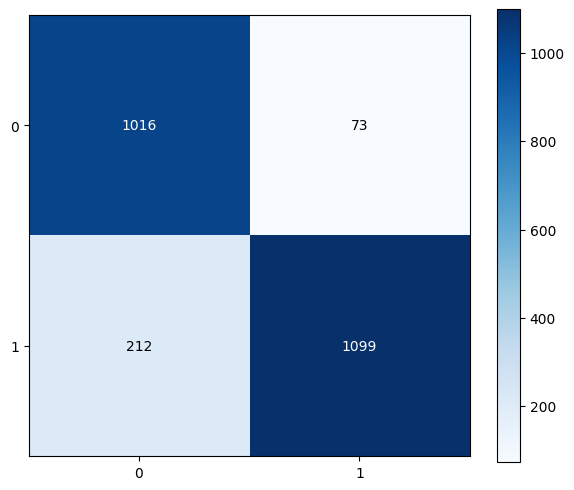

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_file_names.extend(file_names)
        all_scores.extend(probs.tolist())  # Simpan semua skor kelas 0 & 1

# 🔎 Tampilkan 5 contoh hasil
print("\nContoh Prediksi (Top 5):")
for i in range(5):
    fname = all_file_names[i]
    pred = all_preds[i]
    label = all_labels[i]
    score0 = all_scores[i][0]
    score1 = all_scores[i][1]
    print(f"File: {fname} | Label: {label} | Prediksi: {pred} | Score 0: {score0:.4f} | Score 1: {score1:.4f}")

# ✅ Hitung metrik
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("\n🔎 Evaluasi Data Testing")
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")
print("Confusion Matrix:\n", cm)

# 📊 Gambar confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()


In [ ]:
import pandas as pd

# 🚨 Simpan data yang salah prediksi (FP dan FN)
false_positives = []
false_negatives = []

for i in range(len(all_preds)):
    true_label = all_labels[i]
    pred_label = all_preds[i]
    if pred_label != true_label:
        entry = {
            "file_name": all_file_names[i],
            "label": true_label,
            "prediction": pred_label,
            "score_0": all_scores[i][0],
            "score_1": all_scores[i][1]
        }
        if true_label == 0 and pred_label == 1:
            false_positives.append(entry)
        elif true_label == 1 and pred_label == 0:
            false_negatives.append(entry)

# 💾 Simpan ke file CSV
pd.DataFrame(false_positives).to_csv("false_positives.csv", index=False)
pd.DataFrame(false_negatives).to_csv("false_negatives.csv", index=False)

print(f"\n📁 Jumlah False Positives (FP): {len(false_positives)}")
print(f"📁 Jumlah False Negatives (FN): {len(false_negatives)}")
print("✅ Data salah prediksi telah disimpan sebagai 'false_positives.csv' dan 'false_negatives.csv'")



📁 Jumlah False Positives (FP): 82
📁 Jumlah False Negatives (FN): 222
✅ Data salah prediksi telah disimpan sebagai 'false_positives.csv' dan 'false_negatives.csv'


In [ ]:
# Path file input & output
input_path = "/content/drive/MyDrive/Hasil_Ekstraksi/color/validasi_color_tata_letak_only.pt"
output_path = input_path  # bisa diubah kalau mau simpan ke file berbeda

# Load data
data_list = torch.load(input_path, weights_only=False)

print("Jumlah grafik:", len(data_list))
print("Tipe objek pertama:", type(data_list[0]))
print("Isi atribut:", data_list[0])
print(data_list[0].x)

Jumlah grafik: 4320
Tipe objek pertama: <class 'torch_geometric.data.data.Data'>
Isi atribut: Data(x=[9, 12], edge_index=[2, 12], y=0, file_name='17713.jpg')
tensor([[-1.0148,  0.7038, -0.2676, -0.6253,  0.6992, -0.3953, -0.3144,  0.5386,
         -0.5507,  0.0000,  0.0000,  0.7500],
        [-0.9060,  0.3039, -0.3086, -0.6267,  0.4213, -0.3305, -0.4277,  0.6186,
         -0.3639,  0.5000,  0.0000,  0.7500],
        [-1.5388, -0.1790,  0.2618, -1.2648, -0.2942,  0.0706, -0.9412, -0.3804,
         -0.1552,  1.0000,  0.0000,  0.7500],
        [-0.8165,  0.9099, -0.0964, -0.4617,  0.9684, -0.2500, -0.1057,  0.8158,
         -0.4493,  0.0000,  0.5000,  0.7500],
        [ 0.0233,  0.0081, -0.7825,  0.2112,  0.5158, -0.8681,  0.5351,  0.7143,
         -1.0871,  0.5000,  0.5000,  0.7500],
        [-0.4267, -0.0891, -0.4082, -0.0972,  0.1119, -0.4948,  0.1947,  0.2839,
         -0.6520,  1.0000,  0.5000,  0.7500],
        [-0.2837, -0.2293, -0.8155,  0.1959,  0.0685, -0.7819,  0.4111, -0.0261,